In [1]:
# ============================================================
# Local benchmark functions (ZDT1–ZDT6)
#
# These implementations support:
#   - a single decision vector x with shape (n_var,)
#   - a batch of decision vectors X with shape (n_points, n_var)
#
# Notes:
# - All objectives are returned in a 2D array (n_points, 2) for ZDT problems,
#   or (n_points, M) for DTLZ2, except when the input is 1D (then a 1D row is returned).
# - Input validation is kept lightweight to make the functions easy to reuse.
# ============================================================

import numpy as np

def _as_2d(x: np.ndarray) -> tuple[np.ndarray, bool]:
    """Convert input to a 2D array.

    Returns
    -------
    (X2d, was_1d)
        X2d : np.ndarray
            Array with shape (n_points, n_var).
        was_1d : bool
            True if the original input was 1D (single point).
    """
    x = np.asarray(x)
    if x.ndim == 1:
        return x.reshape(1, -1), True
    if x.ndim == 2:
        return x, False
    raise ValueError(f"Input must be 1D or 2D array, got shape {x.shape}")

def _require_min_dim(X: np.ndarray, n_min: int = 2) -> None:
    """Ensure at least n_min decision variables are provided."""
    if X.shape[1] < n_min:
        raise IndexError(f"Input must have at least {n_min} decision variables, got {X.shape[1]}")

def zdt1(x: np.ndarray) -> np.ndarray:
    """ZDT1 (convex Pareto front). Domain: x ∈ [0,1]^n with n≥2."""
    X, was_1d = _as_2d(x)
    _require_min_dim(X, 2)
    f1 = X[:, 0]
    n = X.shape[1]
    g = 1.0 + 9.0 * np.sum(X[:, 1:], axis=1) / (n - 1)
    f2 = g * (1.0 - np.sqrt(f1 / g))
    F = np.column_stack([f1, f2])
    return F[0] if was_1d else F

def zdt2(x: np.ndarray) -> np.ndarray:
    """ZDT2 (concave Pareto front). Domain: x ∈ [0,1]^n with n≥2."""
    X, was_1d = _as_2d(x)
    _require_min_dim(X, 2)
    f1 = X[:, 0]
    n = X.shape[1]
    g = 1.0 + 9.0 * np.sum(X[:, 1:], axis=1) / (n - 1)
    f2 = g * (1.0 - (f1 / g) ** 2)
    F = np.column_stack([f1, f2])
    return F[0] if was_1d else F

def zdt3(x: np.ndarray) -> np.ndarray:
    """ZDT3 (disconnected Pareto front). Domain: x ∈ [0,1]^n with n≥2."""
    X, was_1d = _as_2d(x)
    _require_min_dim(X, 2)
    f1 = X[:, 0]
    n = X.shape[1]
    g = 1.0 + 9.0 * np.sum(X[:, 1:], axis=1) / (n - 1)
    f2 = g * (1.0 - np.sqrt(f1 / g) - (f1 / g) * np.sin(10.0 * np.pi * f1))
    F = np.column_stack([f1, f2])
    return F[0] if was_1d else F

def zdt4(x: np.ndarray) -> np.ndarray:
    """ZDT4 (multimodal, convex PF). Domain: x ∈ [0,1]×[-5,5]^(n-1), n≥2."""
    X, was_1d = _as_2d(x)
    _require_min_dim(X, 2)
    f1 = X[:, 0]
    n = X.shape[1]
    g = 1.0 + 10.0 * (n - 1) + np.sum(X[:, 1:] ** 2 - 10.0 * np.cos(4.0 * np.pi * X[:, 1:]), axis=1)
    f2 = g * (1.0 - np.sqrt(f1 / g))
    F = np.column_stack([f1, f2])
    return F[0] if was_1d else F

def zdt5(x: list[np.ndarray]) -> np.ndarray:
    """ZDT5 (binary-encoded).

    Expects a list of 11 bitstrings (arrays of 0/1 values), consistent with the original definition.
    """
    if len(x) != 11:
        raise IndexError(f"ZDT5 requires 11 variables, got {len(x)}")
    u = [np.sum(xi) for xi in x]
    v = []
    for ui in u[1:]:
        v.append(2 + ui if ui < 5 else 1)
    f1 = 1 + u[0]
    g = np.sum(v)
    f2 = g / f1
    return np.array([f1, f2])

def zdt6(x: np.ndarray) -> np.ndarray:
    """ZDT6 (non-uniform mapping, concave PF). Domain: x ∈ [0,1]^n with n≥2."""
    X, was_1d = _as_2d(x)
    _require_min_dim(X, 2)
    f1 = 1.0 - np.exp(-4.0 * X[:, 0]) * (np.sin(6.0 * np.pi * X[:, 0])) ** 6
    n = X.shape[1]
    g = 1.0 + 9.0 * ((np.sum(X[:, 1:], axis=1) / (n - 1)) ** 0.25)
    f2 = g * (1.0 - (f1 / g) ** 2)
    F = np.column_stack([f1, f2])
    return F[0] if was_1d else F


def dtlz2(x: np.ndarray, M: int = 3, n: int | None = None) -> np.ndarray:
    """DTLZ2 (spherical Pareto front). Domain: x ∈ [0, 1]^n.

    Parameters
    ----------
    x : np.ndarray
        Decision vector (n,) or batch (n_points, n).
    M : int
        Number of objectives.
    n : int | None
        Number of decision variables. If None, uses the common default n = M + 9.
    """
    if n is None:
        n = M + 9

    X, was_1d = _as_2d(x)
    if X.shape[1] != n:
        raise IndexError(f"Input array must have exactly {n} dimensions, got {X.shape[1]}")

    # g-function uses decision variables from index (M-1) to the end
    X_M = X[:, M-1:]
    g = np.sum((X_M - 0.5) ** 2, axis=1)

    # Compute objectives for each row
    F = np.empty((X.shape[0], M), dtype=float)
    for r in range(X.shape[0]):
        xr = X[r]
        gr = g[r]
        for m in range(M):
            val = 1 + gr
            for i in range(M - m - 1):
                val *= np.cos(0.5 * np.pi * xr[i])
            if m > 0:
                val *= np.sin(0.5 * np.pi * xr[M - m - 1])
            F[r, m] = val

    return F[0] if was_1d else F


✓ Total: 700 points (200 ND + 500 Non-optimal)
✔ All ND points are mathematically correct.
✓ Desirability scores range: [0.0000, 0.9403]
DESIRABILITY FUNCTION METRICS
Spearman ρ (D_scores vs -dist_to_PF_dense): 0.4583
Kendall τ (D_scores vs ND-labels):         0.3166
Precision@K (K=200):                        0.5700


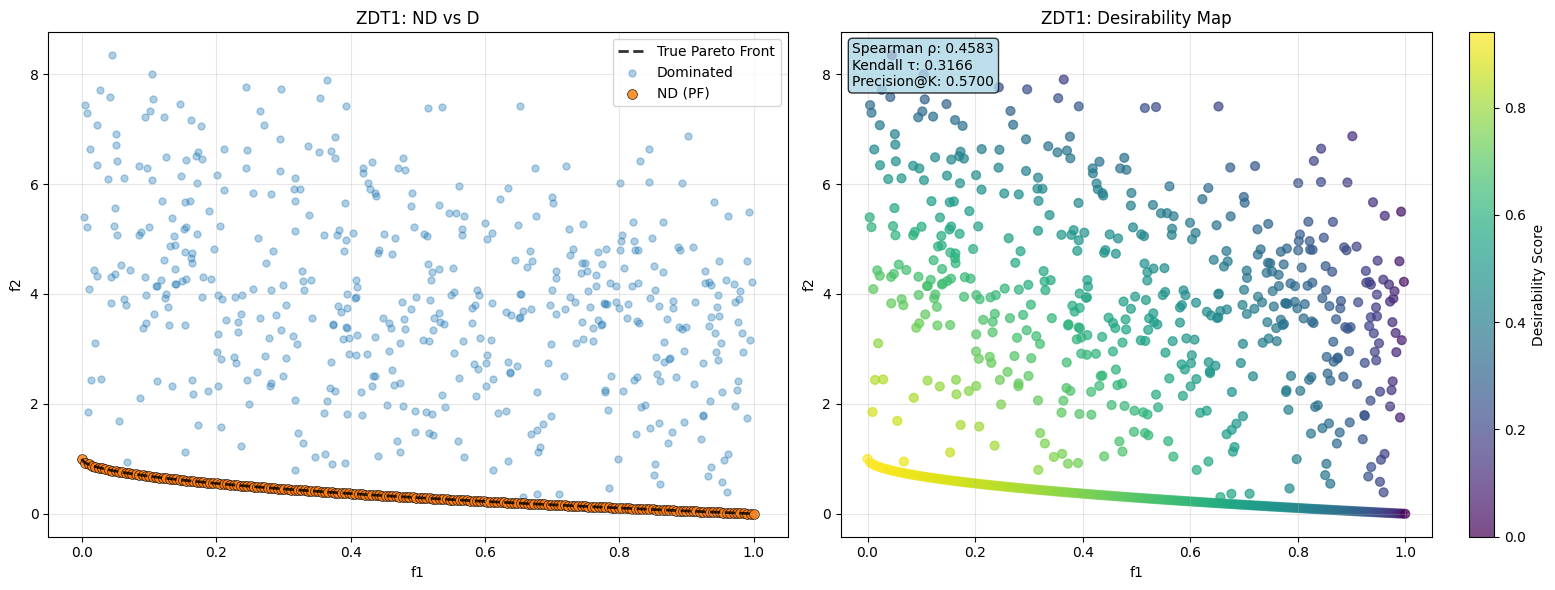


Top 10 Solutions by Desirability Score:
 Rank       f1       f2  Desirability Type
    1 0.005025 0.929112      0.940307   ND
    2 0.010050 0.899749      0.939785   ND
    3 0.015075 0.877218      0.938814   ND
    4 0.000000 1.000000      0.938162   ND
    5 0.020101 0.858224      0.937607   ND
    6 0.025126 0.841489      0.936244   ND
    7 0.030151 0.826360      0.934769   ND
    8 0.035176 0.812448      0.933207   ND
    9 0.040201 0.799498      0.931573   ND
   10 0.045226 0.787336      0.929880   ND


In [2]:
import numpy as np
import matplotlib.pyplot as plt

from spotdesirability.utils.desirability import DMin, DOverall
from scipy.spatial.distance import cdist
from scipy.stats import spearmanr, kendalltau
import pandas as pd


# -----------------------------
# Utilities
# -----------------------------
def generate_pareto_front(n_points=400):
    """Generate the analytical Pareto front for ZDT1 in objective space.

    For ZDT1, the true Pareto front is: f2 = 1 - sqrt(f1), with f1 in [0, 1].
    """
    f1 = np.linspace(0, 1, n_points)
    f2 = 1 - np.sqrt(f1)
    return f1, f2

def check_nd_correctness(F, nd_indices):
    """Verify that the provided indices form a mathematically non-dominated set."""
    ND = F[nd_indices]
    D = np.delete(F, nd_indices, axis=0)
    for a in ND:
        for b in D:
            # b dominates a if b is no worse in all objectives and strictly better in at least one
            if np.all(b <= a) and np.any(b < a):
                print("❌ WRONG ND FOUND:", a)
                return False
    print("✔ All ND points are mathematically correct.")
    return True


# -----------------------------
# Dataset generation (ZDT1)
# -----------------------------
def generate_zdt1_dataset_professor_exact(n_nonopt=500, n_pareto=200, n_vars=30, seed=42):
    """Create a synthetic dataset consisting of:
    - Pareto-optimal samples generated from a known ZDT1 construction (3D embedding)
    - Random dominated samples drawn uniformly from the same decision space

    Returns objective values for:
      F      : all points (Pareto + dominated)
      F_nd   : Pareto front points (objective values)
      F_d    : dominated points (objective values)
      labels : 1 for ND (Pareto), 0 for dominated
    """
    rng = np.random.default_rng(seed)

    # Use a 3-variable construction for the dataset in decision space
    n_vars = 3

    # ---- 1) Pareto-optimal set in decision space: [x1, 0, 0]
    x1_range = np.linspace(0, 1, n_pareto)
    X_pareto = np.column_stack([x1_range, np.zeros((n_pareto, 2))])  # (n_pareto, 3)

    # ---- 2) Dominated set: uniform random samples in [0,1]^3
    X_nonopt = rng.random((n_nonopt, n_vars))  # (n_nonopt, 3)

    # Evaluate ZDT1 in 3D decision space
    F_nd = zdt1(X_pareto)
    F_d  = zdt1(X_nonopt)

    # Combine
    F = np.vstack([F_nd, F_d])
    labels = np.zeros(len(F))
    labels[:n_pareto] = 1  # ND label = 1

    return F, F_nd, F_d, labels


# -----------------------------
# Run
# -----------------------------
n_nonopt = 500
n_pareto = 200
n_vars = 30   # kept as-is; overwritten inside the dataset generator
seed = 42

F, nd_points, d_points, labels = generate_zdt1_dataset_professor_exact(
    n_nonopt=n_nonopt, n_pareto=n_pareto, n_vars=n_vars, seed=seed
)

# Keep downstream configuration consistent with the decision-space construction above
n_vars = 3

K = n_pareto
nds = np.arange(n_pareto)

print(f"✓ Total: {len(F)} points ({len(nd_points)} ND + {len(d_points)} Non-optimal)")
check_nd_correctness(F, nds)

# -----------------------------
# Desirability scoring
# -----------------------------
f1_min, f1_max = F[:, 0].min(), F[:, 0].max()
f2_min, f2_max = F[:, 1].min(), F[:, 1].max()

d_funcs = [DMin(f1_min, f1_max, scale=1),
           DMin(f2_min, f2_max, scale=1)]
D_scores = DOverall(*d_funcs).predict(F)
D_scores = np.maximum(D_scores, 0)

print(f"✓ Desirability scores range: [{D_scores.min():.4f}, {D_scores.max():.4f}]")

# -----------------------------
# Distance-to-front correlation (Spearman)
# Build a dense reference Pareto front in decision space and map it to objective space
# -----------------------------
n_pf_dense = 5000
X_pf_dense = np.zeros((n_pf_dense, n_vars))
X_pf_dense[:, 0] = np.linspace(0, 1, n_pf_dense)  # x1 varies, others=0 => Pareto set
F_pf_dense = zdt1(X_pf_dense)

dist_to_pf = np.min(cdist(F, F_pf_dense), axis=1)
rho_dist, _ = spearmanr(D_scores, -dist_to_pf)

# Kendall + Precision@K
tau, _ = kendalltau(D_scores, labels)
sorted_idx = np.argsort(-D_scores)
topK_idx = sorted_idx[:K]
precision_at_k = labels[topK_idx].sum() / K

print("="*60)
print("DESIRABILITY FUNCTION METRICS")
print("="*60)
print(f"Spearman ρ (D_scores vs -dist_to_PF_dense): {rho_dist:.4f}")
print(f"Kendall τ (D_scores vs ND-labels):         {tau:.4f}")
print(f"Precision@K (K={K}):                        {precision_at_k:.4f}")
print("="*60)

# -----------------------------
# Plots
# -----------------------------
pf_f1, pf_f2 = generate_pareto_front(400)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

axes[0].plot(pf_f1, pf_f2, 'k--', linewidth=2, label='True Pareto Front', alpha=0.8)
axes[0].scatter(d_points[:, 0], d_points[:, 1], s=25, alpha=0.35, label='Dominated')
axes[0].scatter(nd_points[:, 0], nd_points[:, 1], s=50, alpha=0.85, label='ND (PF)',
                edgecolors='black', linewidth=0.5)
axes[0].set_xlabel('f1')
axes[0].set_ylabel('f2')
axes[0].set_title('ZDT1: ND vs D')
axes[0].grid(True, alpha=0.3)
axes[0].legend()

sc = axes[1].scatter(F[:, 0], F[:, 1], c=D_scores, cmap='viridis', s=40, alpha=0.7)
axes[1].set_xlabel('f1')
axes[1].set_ylabel('f2')
axes[1].set_title('ZDT1: Desirability Map')
axes[1].grid(True, alpha=0.3)
cbar = plt.colorbar(sc, ax=axes[1])
cbar.set_label('Desirability Score')

txt = (f"Spearman ρ: {rho_dist:.4f}\n"
       f"Kendall τ: {tau:.4f}\n"
       f"Precision@K: {precision_at_k:.4f}")
axes[1].text(0.02, 0.98, txt, transform=axes[1].transAxes,
             va='top', fontsize=10,
             bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))

plt.tight_layout()
plt.show()

# -----------------------------
# Top 10 solutions
# -----------------------------
top10_idx = sorted_idx[:10]
top10_data = pd.DataFrame({
    'Rank': range(1, 11),
    'f1': F[top10_idx, 0],
    'f2': F[top10_idx, 1],
    'Desirability': D_scores[top10_idx],
    'Type': ['ND' if labels[i] == 1 else 'D' for i in top10_idx]
})
print("\nTop 10 Solutions by Desirability Score:")
print(top10_data.to_string(index=False))


✓ Total: 700 points (200 ND + 500 Non-optimal)
✔ All ND points are mathematically correct.
✓ Desirability scores range: [0.0000, 0.9483]
DESIRABILITY FUNCTION METRICS
Spearman ρ (D_scores vs -dist_to_PF_dense): 0.5932
Kendall τ (D_scores vs ND-labels):         0.3323
Precision@K (K=200):                        0.5700


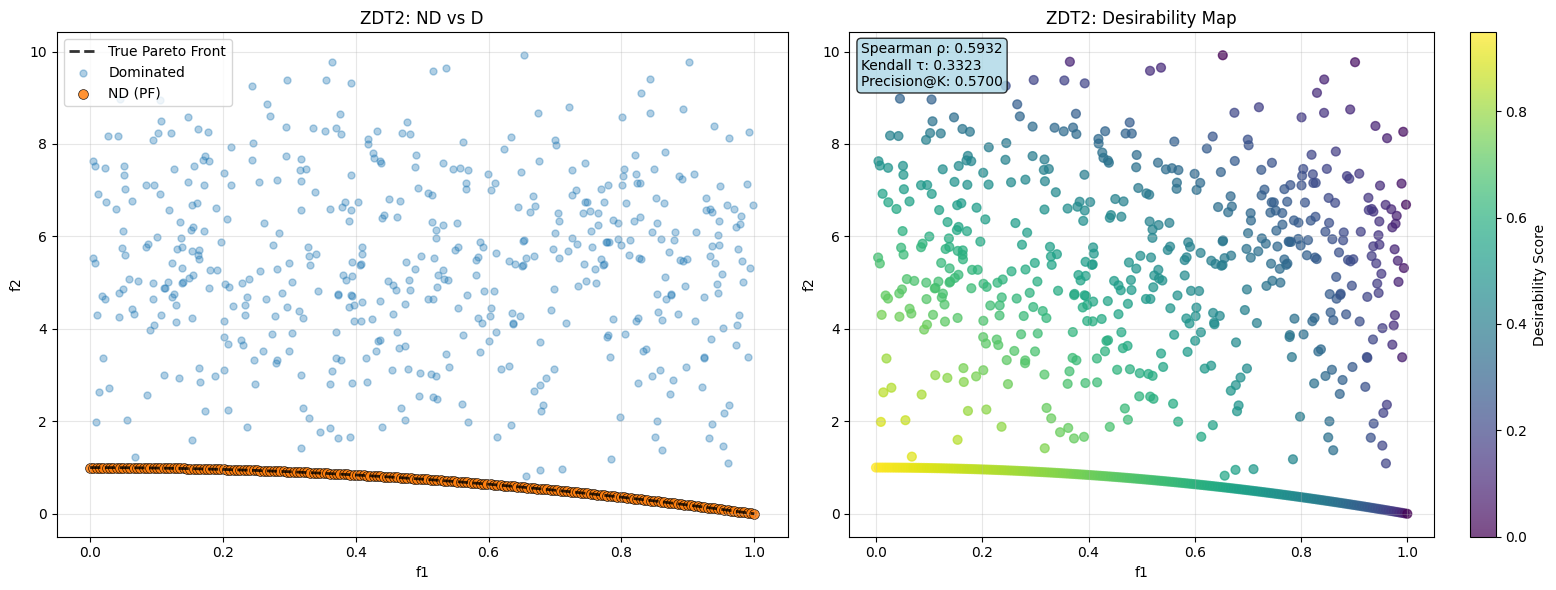


Top 10 Solutions by Desirability Score:
 Rank       f1       f2  Desirability Type
    1 0.000000 1.000000      0.948252   ND
    2 0.005025 0.999975      0.945868   ND
    3 0.010050 0.999899      0.943480   ND
    4 0.015075 0.999773      0.941089   ND
    5 0.020101 0.999596      0.938695   ND
    6 0.025126 0.999369      0.936296   ND
    7 0.030151 0.999091      0.933895   ND
    8 0.035176 0.998763      0.931489   ND
    9 0.040201 0.998384      0.929080   ND
   10 0.045226 0.997955      0.926667   ND


In [3]:
import numpy as np
import matplotlib.pyplot as plt

from spotdesirability.utils.desirability import DMin, DOverall
from scipy.spatial.distance import cdist
from scipy.stats import spearmanr, kendalltau
import pandas as pd


# -----------------------------
# Utilities
# -----------------------------
def generate_pareto_front(n_points=400):
    """Generate the analytical Pareto front for ZDT2 in objective space.

    For ZDT2, the true Pareto front is: f2 = 1 - f1^2, with f1 in [0, 1].
    """
    f1 = np.linspace(0, 1, n_points)
    f2 = 1 - (f1 ** 2)
    return f1, f2

def check_nd_correctness(F, nd_indices):
    """Verify that the provided indices form a mathematically non-dominated set."""
    ND = F[nd_indices]
    D = np.delete(F, nd_indices, axis=0)
    for a in ND:
        for b in D:
            # b dominates a if b is no worse in all objectives and strictly better in at least one
            if np.all(b <= a) and np.any(b < a):
                print("❌ WRONG ND FOUND:", a)
                return False
    print("✔ All ND points are mathematically correct.")
    return True


# -----------------------------
# Dataset generation (ZDT2)
# -----------------------------
def generate_zdt2_dataset_professor_exact(n_nonopt=500, n_pareto=200, n_vars=30, seed=42):
    """Create a synthetic dataset consisting of:
    - Pareto-optimal samples generated from a known ZDT2 construction (3D embedding)
    - Random dominated samples drawn uniformly from the same decision space

    Returns objective values for:
      F      : all points (Pareto + dominated)
      F_nd   : Pareto front points (objective values)
      F_d    : dominated points (objective values)
      labels : 1 for ND (Pareto), 0 for dominated
    """
    rng = np.random.default_rng(seed)

    # Use a 3-variable construction for the dataset in decision space
    n_vars = 3

    # ---- 1) Pareto-optimal set in decision space: [x1, 0, 0]
    x1_range = np.linspace(0, 1, n_pareto)
    X_pareto = np.column_stack([x1_range, np.zeros((n_pareto, 2))])  # (n_pareto, 3)

    # ---- 2) Dominated set: uniform random samples in [0,1]^3
    X_nonopt = rng.random((n_nonopt, n_vars))  # (n_nonopt, 3)

    # Evaluate ZDT2 in 3D decision space
    F_nd = zdt2(X_pareto)
    F_d  = zdt2(X_nonopt)

    # Combine
    F = np.vstack([F_nd, F_d])
    labels = np.zeros(len(F))
    labels[:n_pareto] = 1  # ND label = 1

    return F, F_nd, F_d, labels


# -----------------------------
# Run
# -----------------------------
n_nonopt = 500
n_pareto = 200
n_vars = 30   # kept as-is; overwritten inside the dataset generator
seed = 42

F, nd_points, d_points, labels = generate_zdt2_dataset_professor_exact(
    n_nonopt=n_nonopt, n_pareto=n_pareto, n_vars=n_vars, seed=seed
)

# Keep downstream configuration consistent with the decision-space construction above
n_vars = 3

K = n_pareto
nds = np.arange(n_pareto)

print(f"✓ Total: {len(F)} points ({len(nd_points)} ND + {len(d_points)} Non-optimal)")
check_nd_correctness(F, nds)

# -----------------------------
# Desirability scoring
# -----------------------------
f1_min, f1_max = F[:, 0].min(), F[:, 0].max()
f2_min, f2_max = F[:, 1].min(), F[:, 1].max()

d_funcs = [DMin(f1_min, f1_max, scale=1),
           DMin(f2_min, f2_max, scale=1)]
D_scores = DOverall(*d_funcs).predict(F)
D_scores = np.maximum(D_scores, 0)

print(f"✓ Desirability scores range: [{D_scores.min():.4f}, {D_scores.max():.4f}]")

# -----------------------------
# Distance-to-front correlation (Spearman)
# Build a dense reference Pareto front in decision space and map it to objective space
# -----------------------------
n_pf_dense = 5000
X_pf_dense = np.zeros((n_pf_dense, n_vars))
X_pf_dense[:, 0] = np.linspace(0, 1, n_pf_dense)  # x1 varies, others=0 => Pareto set
F_pf_dense = zdt2(X_pf_dense)

dist_to_pf = np.min(cdist(F, F_pf_dense), axis=1)
rho_dist, _ = spearmanr(D_scores, -dist_to_pf)

# Kendall + Precision@K
tau, _ = kendalltau(D_scores, labels)
sorted_idx = np.argsort(-D_scores)
topK_idx = sorted_idx[:K]
precision_at_k = labels[topK_idx].sum() / K

print("="*60)
print("DESIRABILITY FUNCTION METRICS")
print("="*60)
print(f"Spearman ρ (D_scores vs -dist_to_PF_dense): {rho_dist:.4f}")
print(f"Kendall τ (D_scores vs ND-labels):         {tau:.4f}")
print(f"Precision@K (K={K}):                        {precision_at_k:.4f}")
print("="*60)

# -----------------------------
# Plots
# -----------------------------
pf_f1, pf_f2 = generate_pareto_front(400)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

axes[0].plot(pf_f1, pf_f2, 'k--', linewidth=2, label='True Pareto Front', alpha=0.8)
axes[0].scatter(d_points[:, 0], d_points[:, 1], s=25, alpha=0.35, label='Dominated')
axes[0].scatter(nd_points[:, 0], nd_points[:, 1], s=50, alpha=0.85, label='ND (PF)',
                edgecolors='black', linewidth=0.5)
axes[0].set_xlabel('f1')
axes[0].set_ylabel('f2')
axes[0].set_title('ZDT2: ND vs D')
axes[0].grid(True, alpha=0.3)
axes[0].legend()

sc = axes[1].scatter(F[:, 0], F[:, 1], c=D_scores, cmap='viridis', s=40, alpha=0.7)
axes[1].set_xlabel('f1')
axes[1].set_ylabel('f2')
axes[1].set_title('ZDT2: Desirability Map')
axes[1].grid(True, alpha=0.3)
cbar = plt.colorbar(sc, ax=axes[1])
cbar.set_label('Desirability Score')

txt = (f"Spearman ρ: {rho_dist:.4f}\n"
       f"Kendall τ: {tau:.4f}\n"
       f"Precision@K: {precision_at_k:.4f}")
axes[1].text(0.02, 0.98, txt, transform=axes[1].transAxes,
             va='top', fontsize=10,
             bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))

plt.tight_layout()
plt.show()

# -----------------------------
# Top 10 solutions
# -----------------------------
top10_idx = sorted_idx[:10]
top10_data = pd.DataFrame({
    'Rank': range(1, 11),
    'f1': F[top10_idx, 0],
    'f2': F[top10_idx, 1],
    'Desirability': D_scores[top10_idx],
    'Type': ['ND' if labels[i] == 1 else 'D' for i in top10_idx]
})
print("\nTop 10 Solutions by Desirability Score:")
print(top10_data.to_string(index=False))


✓ Total: 700 points (200 ND + 500 Non-optimal)
✔ All ND points are mathematically correct.
✓ Desirability scores range: [0.0000, 0.8991]
DESIRABILITY FUNCTION METRICS (ZDT3)
Spearman ρ (D_scores vs -dist_to_PF_dense): 0.6866
Kendall τ (D_scores vs ND-labels):         0.5163
Precision@K (K=200):                        0.7700


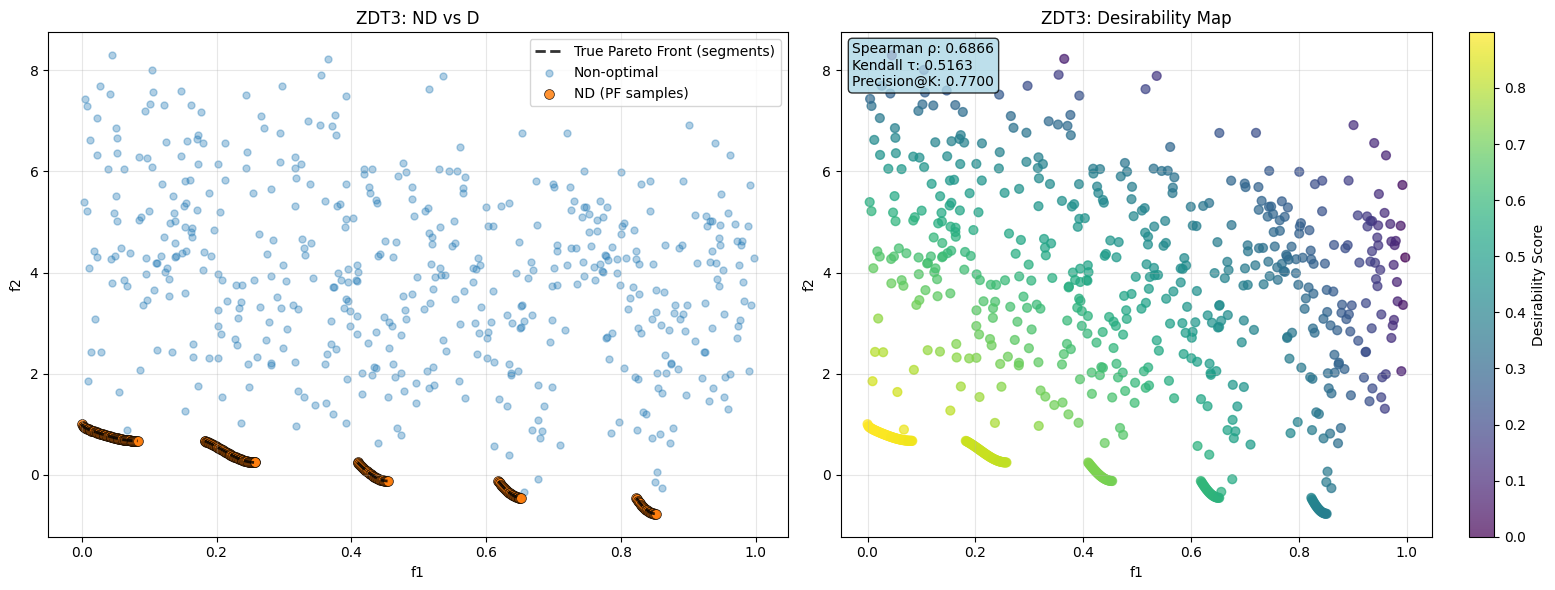


Top 10 Solutions by Desirability Score:
 Rank       f1       f2  Desirability Type
    1 0.005188 0.927134      0.899076   ND
    2 0.003891 0.937151      0.899051   ND
    3 0.006484 0.918163      0.899034   ND
    4 0.007781 0.909905      0.898948   ND
    5 0.002594 0.948860      0.898922   ND
    6 0.009078 0.902167      0.898830   ND
    7 0.010375 0.894820      0.898686   ND
    8 0.001297 0.963935      0.898585   ND
    9 0.011672 0.887779      0.898522   ND
   10 0.012969 0.880981      0.898343   ND
min f2 on PF samples: -0.773369010405526


In [4]:
import numpy as np
import matplotlib.pyplot as plt

from spotdesirability.utils.desirability import DMin, DOverall
from scipy.spatial.distance import cdist
from scipy.stats import spearmanr, kendalltau
import pandas as pd


# -----------------------------
# Utilities (ZDT3: disconnected Pareto front)
# -----------------------------
def _nondominated_mask_2d(f1, f2):
    """Return a non-dominated mask for 2D minimization (f1, f2).

    A point is non-dominated if no other point is <= in both objectives
    and strictly < in at least one objective.
    """
    idx = np.argsort(f1)
    best_f2 = np.inf
    mask = np.zeros_like(f1, dtype=bool)
    for i in idx:
        if f2[i] <= best_f2 + 1e-12:
            mask[i] = True
            best_f2 = f2[i]
    return mask

def _zdt3_pf_formula(f1):
    """ZDT3 Pareto-curve formula for the case g=1 (i.e., x2..=0)."""
    return 1 - np.sqrt(f1) - f1 * np.sin(10 * np.pi * f1)

def _zdt3_true_pf_segments(dense=200000):
    """Identify the disconnected ZDT3 Pareto-front segments in x1-space.

    Approach:
    - sample x1 densely in [0, 1] on the g=1 curve
    - compute (f1, f2) from the analytical formula
    - keep only the non-dominated subset
    - split into segments based on gaps in x1
    Returns
    -------
    segments : list[tuple[float, float]]
        List of (a, b) intervals in x1-space describing each disconnected segment.
    """
    x = np.linspace(0.0, 1.0, dense + 1)
    f1 = x
    f2 = _zdt3_pf_formula(x)

    mask = _nondominated_mask_2d(f1, f2)
    x_nd = x[mask]

    dx = x[1] - x[0]
    gap_idx = np.where(np.diff(x_nd) > 1.5 * dx)[0]

    segments = []
    s = 0
    for g in gap_idx:
        segments.append((x_nd[s], x_nd[g]))
        s = g + 1
    segments.append((x_nd[s], x_nd[-1]))

    return segments

def _allocate_points_to_segments(n_points, segments, min_per_segment=2):
    """Allocate n_points across segments proportional to segment length.

    Ensures:
    - at least min_per_segment per segment
    - total allocated points equals n_points
    """
    lengths = np.array([b - a for a, b in segments], dtype=float)
    weights = lengths / lengths.sum()

    n_per = np.floor(weights * n_points).astype(int)
    n_per = np.maximum(min_per_segment, n_per)

    # Adjust the allocation to match n_points exactly
    while n_per.sum() < n_points:
        n_per[np.argmax(lengths)] += 1
    while n_per.sum() > n_points:
        i = np.argmax(n_per)
        if n_per[i] > min_per_segment:
            n_per[i] -= 1
        else:
            candidates = np.where(n_per > min_per_segment)[0]
            if candidates.size == 0:
                break
            n_per[candidates[np.argmax(n_per[candidates])]] -= 1

    return n_per

def sample_true_pf_x1(n_points, dense=200000):
    """Sample x1 values ONLY from the true ZDT3 Pareto-front segments.

    Returns
    -------
    x_pf : np.ndarray
        Sampled x1 values of length n_points.
    segments : list[tuple[float, float]]
        The discovered disconnected segment intervals in x1-space.
    """
    segments = _zdt3_true_pf_segments(dense=dense)
    n_per = _allocate_points_to_segments(n_points, segments, min_per_segment=2)

    xs = []
    for (a, b), ni in zip(segments, n_per):
        xs.append(np.linspace(a, b, ni))
    x_pf = np.concatenate(xs)

    # Ensure exact length n_points
    if x_pf.size > n_points:
        x_pf = x_pf[:n_points]
    elif x_pf.size < n_points:
        rng = np.random.default_rng(123)
        extra = n_points - x_pf.size
        extra_x = []
        for _ in range(extra):
            seg = rng.integers(0, len(segments))
            a, b = segments[seg]
            extra_x.append(rng.uniform(a, b))
        x_pf = np.concatenate([x_pf, np.array(extra_x)])

    return x_pf, segments

def generate_pareto_front(n_points=400, dense=200000):
    """Create plotting arrays for the disconnected ZDT3 Pareto front.

    NaNs are inserted between segments so that matplotlib does not draw
    connecting lines across gaps.
    """
    x_pf, segments = sample_true_pf_x1(n_points, dense=dense)
    _ = _zdt3_pf_formula(x_pf)  # computed here for completeness; plotting uses per-segment construction below

    # Re-generate per segment for clean separation and NaN gaps
    n_per = _allocate_points_to_segments(n_points, segments, min_per_segment=2)
    f1_plot, f2_plot = [], []
    for (a, b), ni in zip(segments, n_per):
        x = np.linspace(a, b, ni)
        y = _zdt3_pf_formula(x)
        f1_plot.append(x)
        f2_plot.append(y)
        f1_plot.append(np.array([np.nan]))
        f2_plot.append(np.array([np.nan]))

    return np.concatenate(f1_plot), np.concatenate(f2_plot)

def check_nd_correctness(F, nd_indices):
    """Verify that the provided indices form a mathematically non-dominated set."""
    ND = F[nd_indices]
    D = np.delete(F, nd_indices, axis=0)
    for a in ND:
        for b in D:
            if np.all(b <= a) and np.any(b < a):
                print("❌ WRONG ND FOUND:", a)
                return False
    print("✔ All ND points are mathematically correct.")
    return True


# -----------------------------
# Dataset generation (ZDT3)
# Decision-space construction: 3 variables, no padding
# PF samples: [x1, 0, 0] with x1 restricted to true PF segments
# -----------------------------
def generate_zdt3_dataset_professor_exact(n_nonopt=500, n_pareto=200, n_vars=30, seed=42):
    rng = np.random.default_rng(seed)

    # Use a 3-variable construction for the dataset in decision space
    n_vars = 3

    # ---- 1) Pareto-optimal set: [x1, 0, 0] with x1 sampled from true PF segments
    x1_pf, segments = sample_true_pf_x1(n_pareto, dense=200000)
    X_pareto = np.column_stack([x1_pf, np.zeros((n_pareto, 2))])

    # ---- 2) Dominated set: uniform random samples in [0,1]^3
    X_nonopt = rng.random((n_nonopt, n_vars))

    # Evaluate
    F_nd = zdt3(X_pareto)
    F_d  = zdt3(X_nonopt)

    # Combine
    F = np.vstack([F_nd, F_d])
    labels = np.zeros(len(F))
    labels[:n_pareto] = 1

    return F, F_nd, F_d, labels


# -----------------------------
# Run
# -----------------------------
n_nonopt = 500
n_pareto = 200
n_vars = 30
seed = 42

F, nd_points, d_points, labels = generate_zdt3_dataset_professor_exact(
    n_nonopt=n_nonopt, n_pareto=n_pareto, n_vars=n_vars, seed=seed
)

# Keep downstream configuration consistent with the decision-space construction above
n_vars = 3

K = n_pareto
nds = np.arange(n_pareto)

print(f"✓ Total: {len(F)} points ({len(nd_points)} ND + {len(d_points)} Non-optimal)")
check_nd_correctness(F, nds)

# -----------------------------
# Desirability scoring
# -----------------------------
f1_min, f1_max = F[:, 0].min(), F[:, 0].max()
f2_min, f2_max = F[:, 1].min(), F[:, 1].max()

d_funcs = [DMin(f1_min, f1_max, scale=1),
           DMin(f2_min, f2_max, scale=1)]
D_scores = DOverall(*d_funcs).predict(F)
D_scores = np.maximum(D_scores, 0)

print(f"✓ Desirability scores range: [{D_scores.min():.4f}, {D_scores.max():.4f}]")

# -----------------------------
# Distance-to-front correlation (Spearman)
# Dense reference front sampled only from true PF segments
# -----------------------------
n_pf_dense = 20000
x1_dense, _ = sample_true_pf_x1(n_pf_dense, dense=200000)

X_pf_dense = np.zeros((len(x1_dense), n_vars))
X_pf_dense[:, 0] = x1_dense
F_pf_dense = zdt3(X_pf_dense)

dist_to_pf = np.min(cdist(F, F_pf_dense), axis=1)
rho_dist, _ = spearmanr(D_scores, -dist_to_pf)

# Kendall + Precision@K
tau, _ = kendalltau(D_scores, labels)
sorted_idx = np.argsort(-D_scores)
topK_idx = sorted_idx[:K]
precision_at_k = labels[topK_idx].sum() / K

print("="*60)
print("DESIRABILITY FUNCTION METRICS (ZDT3)")
print("="*60)
print(f"Spearman ρ (D_scores vs -dist_to_PF_dense): {rho_dist:.4f}")
print(f"Kendall τ (D_scores vs ND-labels):         {tau:.4f}")
print(f"Precision@K (K={K}):                        {precision_at_k:.4f}")
print("="*60)

# -----------------------------
# Plots
# -----------------------------
pf_f1, pf_f2 = generate_pareto_front(400, dense=200000)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

axes[0].plot(pf_f1, pf_f2, 'k--', linewidth=2, label='True Pareto Front (segments)', alpha=0.8)
axes[0].scatter(d_points[:, 0], d_points[:, 1], s=25, alpha=0.35, label='Non-optimal')
axes[0].scatter(nd_points[:, 0], nd_points[:, 1], s=50, alpha=0.85, label='ND (PF samples)',
                edgecolors='black', linewidth=0.5)
axes[0].set_xlabel('f1')
axes[0].set_ylabel('f2')
axes[0].set_title('ZDT3: ND vs D')
axes[0].grid(True, alpha=0.3)
axes[0].legend()

sc = axes[1].scatter(F[:, 0], F[:, 1], c=D_scores, cmap='viridis', s=40, alpha=0.7)
axes[1].set_xlabel('f1')
axes[1].set_ylabel('f2')
axes[1].set_title('ZDT3: Desirability Map')
axes[1].grid(True, alpha=0.3)
cbar = plt.colorbar(sc, ax=axes[1])
cbar.set_label('Desirability Score')

txt = (f"Spearman ρ: {rho_dist:.4f}\n"
       f"Kendall τ: {tau:.4f}\n"
       f"Precision@K: {precision_at_k:.4f}")
axes[1].text(0.02, 0.98, txt, transform=axes[1].transAxes,
             va='top', fontsize=10,
             bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))

plt.tight_layout()
plt.show()

# -----------------------------
# Top 10 solutions
# -----------------------------
top10_idx = sorted_idx[:10]
top10_data = pd.DataFrame({
    'Rank': range(1, 11),
    'f1': F[top10_idx, 0],
    'f2': F[top10_idx, 1],
    'Desirability': D_scores[top10_idx],
    'Type': ['ND' if labels[i] == 1 else 'D' for i in top10_idx]
})
print("\nTop 10 Solutions by Desirability Score:")
print(top10_data.to_string(index=False))

# Quick check for PF sample quality (lower is better for f2 in this benchmark)
print("min f2 on PF samples:", nd_points[:, 1].min())


✓ Total: 700 points (200 ND + 500 Non-optimal)
✔ All ND points are mathematically correct.
✓ Desirability scores range: [0.0000, 0.9981]
DESIRABILITY FUNCTION METRICS (ZDT4)
Spearman ρ (D_scores vs -dist_to_PF_dense): 0.4781
Kendall τ (D_scores vs ND-labels):         0.3887
Precision@K (K=200):                        0.6500


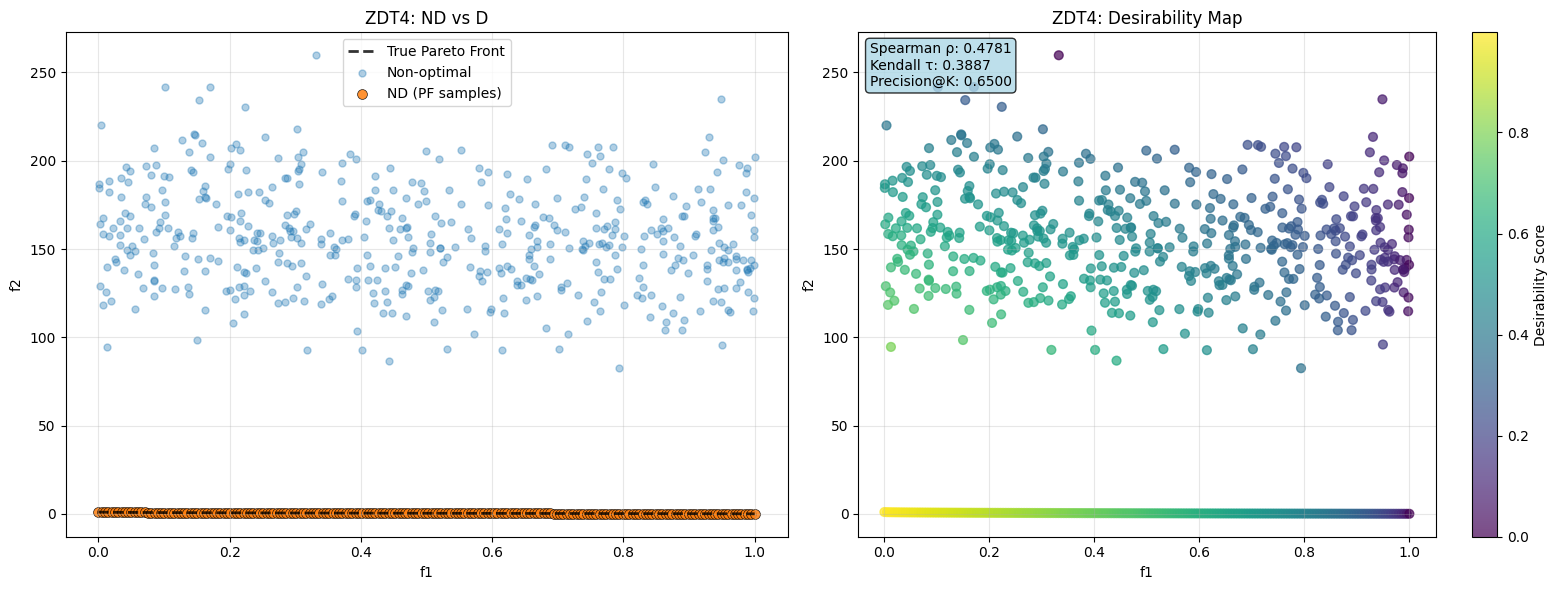


Top 10 Solutions by Desirability Score:
 Rank       f1       f2  Desirability Type
    1 0.000000 1.000000      0.998073   ND
    2 0.005025 0.929112      0.995699   ND
    3 0.010050 0.899749      0.993238   ND
    4 0.015075 0.877218      0.990757   ND
    5 0.020101 0.858224      0.988262   ND
    6 0.025126 0.841489      0.985757   ND
    7 0.030151 0.826360      0.983242   ND
    8 0.035176 0.812448      0.980717   ND
    9 0.040201 0.799498      0.978185   ND
   10 0.045226 0.787336      0.975643   ND


In [5]:
import numpy as np
import matplotlib.pyplot as plt

from spotdesirability.utils.desirability import DMin, DOverall
from scipy.spatial.distance import cdist
from scipy.stats import spearmanr, kendalltau
import pandas as pd


# -----------------------------
# Utilities
# -----------------------------
def generate_pareto_front(n_points=400):
    """Generate the analytical Pareto front curve for ZDT4 in objective space.

    For ZDT4, the Pareto-optimal set satisfies x2..x10 = 0, which implies g = 1.
    In that case, the Pareto front in objective space matches ZDT1:
      f2 = 1 - sqrt(f1), with f1 in [0, 1].
    """
    f1 = np.linspace(0, 1, n_points)
    f2 = 1 - np.sqrt(f1)
    return f1, f2

def check_nd_correctness(F, nd_indices):
    """Verify that the provided indices form a mathematically non-dominated set."""
    ND = F[nd_indices]
    D = np.delete(F, nd_indices, axis=0)
    for a in ND:
        for b in D:
            # b dominates a if b is no worse in all objectives and strictly better in at least one
            if np.all(b <= a) and np.any(b < a):
                print("❌ WRONG ND FOUND:", a)
                return False
    print("✔ All ND points are mathematically correct.")
    return True


# -----------------------------
# Dataset generation (ZDT4)
# Decision-space construction: 10 variables, no padding
# -----------------------------
def generate_zdt4_dataset_professor_exact(n_nonopt=500, n_pareto=200, seed=42):
    """Create a synthetic dataset consisting of:
    - Pareto-optimal samples constructed as [x1, 0, 0, ..., 0] in 10D
    - Dominated samples drawn from the ZDT4 domain:
        x1 in [0, 1], and x2..x10 in [-5, 5]

    Returns objective values for:
      F      : all points (Pareto + dominated)
      F_nd   : Pareto front points (objective values)
      F_d    : dominated points (objective values)
      labels : 1 for ND (Pareto), 0 for dominated
    """
    rng = np.random.default_rng(seed)

    # ZDT4 default dimension used here
    n_vars = 10

    # ---- 1) Pareto-optimal set in decision space: [x1, 0, 0, ..., 0]
    x1_range = np.linspace(0, 1, n_pareto)
    X_pareto = np.column_stack([x1_range, np.zeros((n_pareto, n_vars - 1))])  # (n_pareto, 10)

    # ---- 2) Dominated set: x1 in [0,1], others in [-5,5]
    X_nonopt = rng.random((n_nonopt, n_vars))          # [0,1]
    X_nonopt[:, 1:] = X_nonopt[:, 1:] * 10.0 - 5.0     # [-5, 5] for x2..x10

    # Evaluate in 10D decision space
    F_nd = zdt4(X_pareto)
    F_d  = zdt4(X_nonopt)

    # Combine
    F = np.vstack([F_nd, F_d])
    labels = np.zeros(len(F))
    labels[:n_pareto] = 1  # ND label = 1

    return F, F_nd, F_d, labels


# -----------------------------
# Run
# -----------------------------
n_nonopt = 500
n_pareto = 200
seed = 42

F, nd_points, d_points, labels = generate_zdt4_dataset_professor_exact(
    n_nonopt=n_nonopt, n_pareto=n_pareto, seed=seed
)

# Keep downstream configuration consistent with the decision-space construction above
n_vars = 10

K = n_pareto
nds = np.arange(n_pareto)

print(f"✓ Total: {len(F)} points ({len(nd_points)} ND + {len(d_points)} Non-optimal)")
check_nd_correctness(F, nds)

# -----------------------------
# Desirability scoring
# -----------------------------
f1_min, f1_max = F[:, 0].min(), F[:, 0].max()
f2_min, f2_max = F[:, 1].min(), F[:, 1].max()

d_funcs = [DMin(f1_min, f1_max, scale=1),
           DMin(f2_min, f2_max, scale=1)]
D_scores = DOverall(*d_funcs).predict(F)
D_scores = np.maximum(D_scores, 0)

print(f"✓ Desirability scores range: [{D_scores.min():.4f}, {D_scores.max():.4f}]")

# -----------------------------
# Distance-to-front correlation (Spearman)
# Dense reference front constructed in decision space and mapped to objective space
# -----------------------------
n_pf_dense = 5000
X_pf_dense = np.zeros((n_pf_dense, n_vars))
X_pf_dense[:, 0] = np.linspace(0, 1, n_pf_dense)  # x1 varies, others=0 => Pareto set
F_pf_dense = zdt4(X_pf_dense)

dist_to_pf = np.min(cdist(F, F_pf_dense), axis=1)
rho_dist, _ = spearmanr(D_scores, -dist_to_pf)

# Kendall + Precision@K
tau, _ = kendalltau(D_scores, labels)
sorted_idx = np.argsort(-D_scores)
topK_idx = sorted_idx[:K]
precision_at_k = labels[topK_idx].sum() / K

print("="*60)
print("DESIRABILITY FUNCTION METRICS (ZDT4)")
print("="*60)
print(f"Spearman ρ (D_scores vs -dist_to_PF_dense): {rho_dist:.4f}")
print(f"Kendall τ (D_scores vs ND-labels):         {tau:.4f}")
print(f"Precision@K (K={K}):                        {precision_at_k:.4f}")
print("="*60)

# -----------------------------
# Plots
# -----------------------------
pf_f1, pf_f2 = generate_pareto_front(400)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

axes[0].plot(pf_f1, pf_f2, 'k--', linewidth=2, label='True Pareto Front', alpha=0.8)
axes[0].scatter(d_points[:, 0], d_points[:, 1], s=25, alpha=0.35, label='Non-optimal')
axes[0].scatter(nd_points[:, 0], nd_points[:, 1], s=50, alpha=0.85, label='ND (PF samples)',
                edgecolors='black', linewidth=0.5)
axes[0].set_xlabel('f1')
axes[0].set_ylabel('f2')
axes[0].set_title('ZDT4: ND vs D')
axes[0].grid(True, alpha=0.3)
axes[0].legend()

sc = axes[1].scatter(F[:, 0], F[:, 1], c=D_scores, cmap='viridis', s=40, alpha=0.7)
axes[1].set_xlabel('f1')
axes[1].set_ylabel('f2')
axes[1].set_title('ZDT4: Desirability Map')
axes[1].grid(True, alpha=0.3)
cbar = plt.colorbar(sc, ax=axes[1])
cbar.set_label('Desirability Score')

txt = (f"Spearman ρ: {rho_dist:.4f}\n"
       f"Kendall τ: {tau:.4f}\n"
       f"Precision@K: {precision_at_k:.4f}")
axes[1].text(0.02, 0.98, txt, transform=axes[1].transAxes,
             va='top', fontsize=10,
             bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))

plt.tight_layout()
plt.show()

# -----------------------------
# Top 10 solutions
# -----------------------------
top10_idx = sorted_idx[:10]
top10_data = pd.DataFrame({
    'Rank': range(1, 11),
    'f1': F[top10_idx, 0],
    'f2': F[top10_idx, 1],
    'Desirability': D_scores[top10_idx],
    'Type': ['ND' if labels[i] == 1 else 'D' for i in top10_idx]
})
print("\nTop 10 Solutions by Desirability Score:")
print(top10_data.to_string(index=False))


✓ Total: 700 points (200 ND + 500 Non-optimal)
✔ All ND points are mathematically correct.
✓ Desirability scores range: [0.0000, 0.9462]
DESIRABILITY FUNCTION METRICS (ZDT6 - better sampling)
Spearman ρ (D_scores vs -dist_to_PF_dense): 0.6473
Kendall τ (D_scores vs ND-labels):         0.4558
Precision@K (K=200):                        0.7150


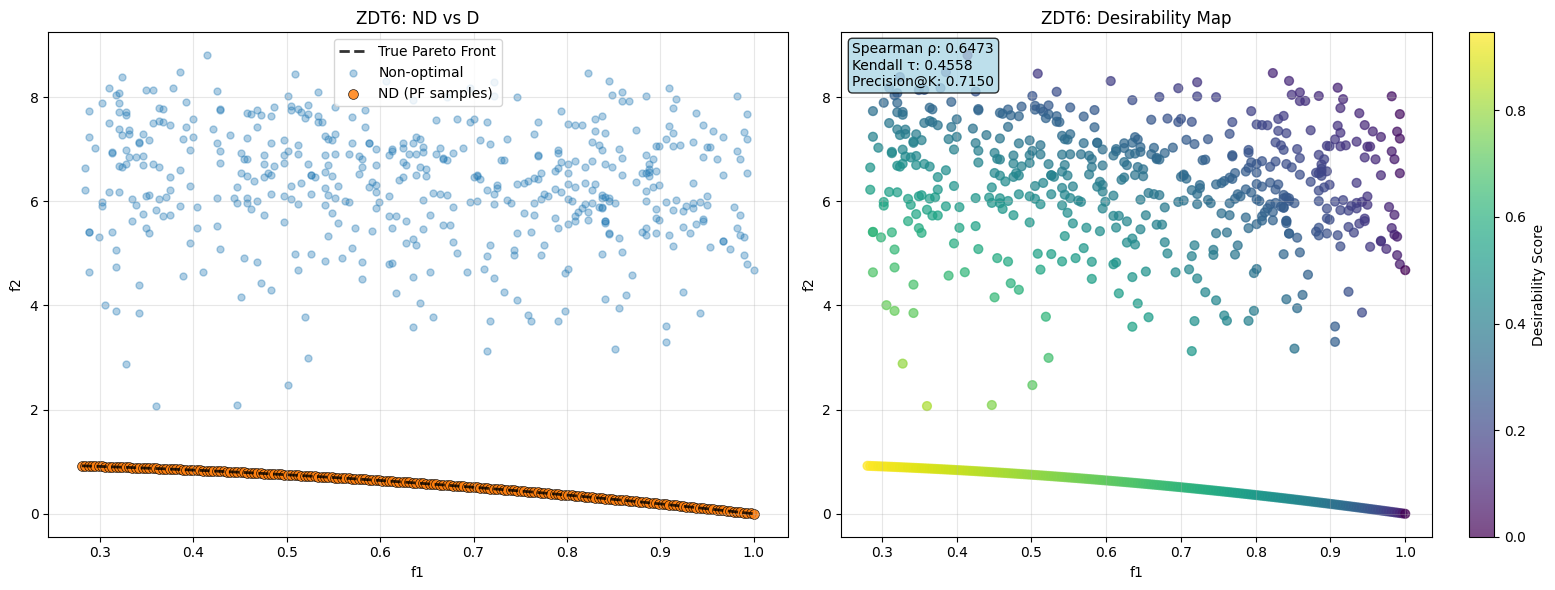


Top 10 Solutions by Desirability Score:
 Rank       f1       f2  Desirability Type
    1 0.280775 0.921165      0.946239   ND
    2 0.284387 0.919124      0.943983   ND
    3 0.288003 0.917054      0.941718   ND
    4 0.291615 0.914961      0.939451   ND
    5 0.295226 0.912842      0.937180   ND
    6 0.298833 0.910699      0.934905   ND
    7 0.302460 0.908518      0.932613   ND
    8 0.306061 0.906326      0.930331   ND
    9 0.309695 0.904089      0.928024   ND
   10 0.313306 0.901839      0.925725   ND


In [6]:
import numpy as np
import matplotlib.pyplot as plt

from spotdesirability.utils.desirability import DMin, DOverall
from scipy.spatial.distance import cdist
from scipy.stats import spearmanr, kendalltau
import pandas as pd


# -----------------------------
# Utilities (ZDT6: non-uniform mapping)
# -----------------------------
def generate_pareto_front_zdt6(n_points=400, dense=200000):
    """Generate the ZDT6 Pareto front in objective space for plotting (g=1 case).

    When x2.. = 0, we have g = 1 and the Pareto front is:
      f1 = 1 - exp(-4 x1) * sin(6πx1)^6
      f2 = 1 - f1^2

    Since f1(x1) is non-uniform over x1, a dense sampling is created first,
    then downsampled for plotting.
    """
    x1 = np.linspace(0, 1, dense)
    f1 = 1 - np.exp(-4 * x1) * (np.sin(6 * np.pi * x1) ** 6)
    f2 = 1 - f1**2

    # Sort by f1 so the curve is monotonic in the plotting direction
    order = np.argsort(f1)
    f1, f2 = f1[order], f2[order]

    # Downsample to n_points
    idx = np.linspace(0, len(f1) - 1, n_points).astype(int)
    return f1[idx], f2[idx]


def check_nd_correctness(F, nd_indices):
    """Verify that the provided indices form a mathematically non-dominated set."""
    ND = F[nd_indices]
    D = np.delete(F, nd_indices, axis=0)
    for a in ND:
        for b in D:
            if np.all(b <= a) and np.any(b < a):
                print("❌ WRONG ND FOUND:", a)
                return False
    print("✔ All ND points are mathematically correct.")
    return True


# -----------------------------
# Sampling strategy for ZDT6
#   - ND set: constructed with g=1 (x2.. = 0)
#   - D set: constructed to be dominated by matching ND points (same x1, g>1)
# -----------------------------
def _sample_x1_uniform_in_f1(n_points, dense=200000, avoid_one_eps=1e-6):
    """Sample x1 so that resulting f1 values are approximately uniform.

    For ZDT6, the mapping x1 -> f1 is highly non-linear and can create clustering
    in objective space if x1 is sampled uniformly. This routine selects x1 values
    such that f1(x1) spans its range more evenly.

    Notes
    -----
    - Because f1(x1) is not strictly one-to-one, the selection is done greedily
      with a "use each dense index once" heuristic to reduce duplicates.
    - The upper end near f1=1 is avoided to reduce repeated values.
    """
    x1_dense = np.linspace(0, 1, dense)
    f1_dense = 1 - np.exp(-4 * x1_dense) * (np.sin(6 * np.pi * x1_dense) ** 6)

    f1_min = float(f1_dense.min())
    f1_max = float(f1_dense.max())

    # Avoid exactly f1=1.0 (many x1 map close to 1 -> duplicates)
    f1_targets = np.linspace(f1_min, f1_max - avoid_one_eps, n_points)

    used = np.zeros(dense, dtype=bool)
    x1_out = np.zeros(n_points)

    for i, t in enumerate(f1_targets):
        dif = np.abs(f1_dense - t)

        # Take a small candidate set and pick the first unused index
        cand = np.argpartition(dif, 200)[:200]
        cand = cand[np.argsort(dif[cand])]

        chosen = None
        for idx in cand:
            if not used[idx]:
                chosen = idx
                break
        if chosen is None:
            chosen = cand[0]

        used[chosen] = True
        x1_out[i] = x1_dense[chosen]

    return np.clip(x1_out, 0.0, 1.0)


def generate_zdt6_dataset_better_sampling(n_nonopt=500, n_pareto=200, seed=42,
                                         n_vars=10, dense_map=200000):
    """Create a ZDT6 dataset with controlled dominance structure.

    ND set:
      - x2..x_n = 0  => g = 1 (Pareto-optimal construction)
      - x1 sampled to spread points more evenly in objective space (via f1-uniform sampling)

    Dominated set:
      - uses the same x1 values as ND points so each dominated point has a matching reference
      - activates additional decision variables (x2..x_n) to enforce g > 1, making points dominated
      - includes a mix of "close/medium/far" dominated points by varying the number of active vars
    """
    rng = np.random.default_rng(seed)

    # --- 1) PF samples (ND): x2.. = 0
    x1_pf = _sample_x1_uniform_in_f1(n_pareto, dense=dense_map)
    X_pareto = np.zeros((n_pareto, n_vars))
    X_pareto[:, 0] = x1_pf
    F_nd = zdt6(X_pareto)

    # --- 2) Dominated samples: enforce g > 1 by activating x2..x_n
    X_nonopt = np.zeros((n_nonopt, n_vars))

    # Mix of dominance severity controlled by the count of active variables
    n_close = int(n_nonopt * 0.50)         # 50%
    n_medium = int(n_nonopt * 0.35)        # 35%
    n_far = n_nonopt - n_close - n_medium  # 15%

    idx = 0

    def make_d_point(total_vars_active):
        # total_vars_active includes x1
        x = np.zeros(n_vars)

        # choose x1 from the PF set so a matching ND point exists
        j = rng.integers(0, n_pareto)
        x[0] = x1_pf[j]

        # activate a subset of x2..x_n with positive values to increase g
        n_extra = max(1, total_vars_active - 1)
        cols = rng.choice(np.arange(1, n_vars), size=n_extra, replace=False)
        x[cols] = rng.uniform(1e-3, 1.0, size=n_extra)
        return x

    for _ in range(n_close):
        total_active = rng.integers(2, 4)  # x1 + (1..2) vars
        X_nonopt[idx] = make_d_point(total_active); idx += 1

    for _ in range(n_medium):
        total_active = rng.integers(4, 6)  # x1 + (3..4) vars
        X_nonopt[idx] = make_d_point(total_active); idx += 1

    for _ in range(n_far):
        total_active = rng.integers(6, 9)  # x1 + (5..8) vars
        total_active = min(total_active, n_vars)  # safety
        X_nonopt[idx] = make_d_point(total_active); idx += 1

    F_d = zdt6(X_nonopt)

    # Combine
    F = np.vstack([F_nd, F_d])
    labels = np.zeros(len(F))
    labels[:n_pareto] = 1

    return F, F_nd, F_d, labels


# -----------------------------
# Run
# -----------------------------
n_nonopt = 500
n_pareto = 200
seed = 42
n_vars = 10  # ZDT6 is commonly evaluated with 10 decision variables

F, nd_points, d_points, labels = generate_zdt6_dataset_better_sampling(
    n_nonopt=n_nonopt, n_pareto=n_pareto, seed=seed, n_vars=n_vars, dense_map=200000
)

K = n_pareto
nds = np.arange(n_pareto)

print(f"✓ Total: {len(F)} points ({len(nd_points)} ND + {len(d_points)} Non-optimal)")
check_nd_correctness(F, nds)

# -----------------------------
# Desirability scoring
# -----------------------------
f1_min, f1_max = F[:, 0].min(), F[:, 0].max()
f2_min, f2_max = F[:, 1].min(), F[:, 1].max()

d_funcs = [DMin(f1_min, f1_max, scale=1),
           DMin(f2_min, f2_max, scale=1)]
D_scores = DOverall(*d_funcs).predict(F)
D_scores = np.maximum(D_scores, 0)

print(f"✓ Desirability scores range: [{D_scores.min():.4f}, {D_scores.max():.4f}]")

# -----------------------------
# Distance-to-front correlation (Spearman)
# Dense reference PF constructed with f1-uniform sampling
# -----------------------------
n_pf_dense = 5000
x1_dense = _sample_x1_uniform_in_f1(n_pf_dense, dense=300000)  # denser for PF distance estimate
X_pf_dense = np.zeros((n_pf_dense, n_vars))
X_pf_dense[:, 0] = x1_dense
F_pf_dense = zdt6(X_pf_dense)

dist_to_pf = np.min(cdist(F, F_pf_dense), axis=1)
rho_dist, _ = spearmanr(D_scores, -dist_to_pf)

# Kendall + Precision@K
tau, _ = kendalltau(D_scores, labels)
sorted_idx = np.argsort(-D_scores)
topK_idx = sorted_idx[:K]
precision_at_k = labels[topK_idx].sum() / K

print("="*60)
print("DESIRABILITY FUNCTION METRICS (ZDT6 - better sampling)")
print("="*60)
print(f"Spearman ρ (D_scores vs -dist_to_PF_dense): {rho_dist:.4f}")
print(f"Kendall τ (D_scores vs ND-labels):         {tau:.4f}")
print(f"Precision@K (K={K}):                        {precision_at_k:.4f}")
print("="*60)

# -----------------------------
# Plots
# -----------------------------
pf_f1, pf_f2 = generate_pareto_front_zdt6(n_points=400)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

axes[0].plot(pf_f1, pf_f2, 'k--', linewidth=2, label='True Pareto Front', alpha=0.8)
axes[0].scatter(d_points[:, 0], d_points[:, 1], s=25, alpha=0.35, label='Non-optimal')
axes[0].scatter(nd_points[:, 0], nd_points[:, 1], s=50, alpha=0.85, label='ND (PF samples)',
                edgecolors='black', linewidth=0.5)
axes[0].set_xlabel('f1')
axes[0].set_ylabel('f2')
axes[0].set_title('ZDT6: ND vs D')
axes[0].grid(True, alpha=0.3)
axes[0].legend()

sc = axes[1].scatter(F[:, 0], F[:, 1], c=D_scores, cmap='viridis', s=40, alpha=0.7)
axes[1].set_xlabel('f1')
axes[1].set_ylabel('f2')
axes[1].set_title('ZDT6: Desirability Map')
axes[1].grid(True, alpha=0.3)
cbar = plt.colorbar(sc, ax=axes[1])
cbar.set_label('Desirability Score')

txt = (f"Spearman ρ: {rho_dist:.4f}\n"
       f"Kendall τ: {tau:.4f}\n"
       f"Precision@K: {precision_at_k:.4f}")
axes[1].text(0.02, 0.98, txt, transform=axes[1].transAxes,
             va='top', fontsize=10,
             bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))

plt.tight_layout()
plt.show()

# -----------------------------
# Top 10 solutions
# -----------------------------
top10_idx = sorted_idx[:10]
top10_data = pd.DataFrame({
    'Rank': range(1, 11),
    'f1': F[top10_idx, 0],
    'f2': F[top10_idx, 1],
    'Desirability': D_scores[top10_idx],
    'Type': ['ND' if labels[i] == 1 else 'D' for i in top10_idx]
})
print("\nTop 10 Solutions by Desirability Score:")
print(top10_data.to_string(index=False))


In [8]:
# ============================================================
# Local benchmark functions (DTLZ1–DTLZ7)
#
# - Flexible w.r.t. dimensionality: n can be provided explicitly or inferred from input.
# - Supports both:
#     * single decision vector x with shape (n,)
#     * batch of decision vectors X with shape (n_points, n)
#
# Conventions:
# - Minimization is assumed for all objectives.
# - Returns:
#     * 1D array (n_obj,) for single-point input
#     * 2D array (n_points, n_obj) for batch input
# ============================================================

import numpy as np

def _as_2d(x: np.ndarray) -> tuple[np.ndarray, bool]:
    """Convert input to a 2D float array and indicate whether it was originally 1D."""
    x = np.asarray(x, dtype=float)
    was_1d = (x.ndim == 1)
    if was_1d:
        x = x.reshape(1, -1)
    if x.ndim != 2:
        raise ValueError("Input x must be a 1D or 2D array.")
    return x, was_1d

def _infer_n(X: np.ndarray, n: int | None) -> int:
    """Infer number of decision variables from input unless n is explicitly provided."""
    return X.shape[1] if n is None else int(n)

def _check_dims(X: np.ndarray, n_obj: int, n: int) -> None:
    """Validate objective count and dimensional consistency."""
    if n_obj < 2:
        raise ValueError(f"n_obj must be >= 2, got {n_obj}")
    if X.shape[1] != n:
        raise IndexError(f"Input must have {n} variables, got {X.shape[1]}")
    if n < n_obj:
        raise IndexError(f"n must be >= n_obj (n={n}, n_obj={n_obj})")

def dtlz1(x: np.ndarray, n_obj: int = 3, n: int | None = None) -> np.ndarray:
    """DTLZ1 (linear Pareto front; multimodal landscape via g). Domain: x ∈ [0,1]^n."""
    X, was_1d = _as_2d(x)
    n = _infer_n(X, n)
    _check_dims(X, n_obj, n)

    k = n - n_obj + 1
    X_M = X[:, n_obj-1:]
    g = 100.0 * (k + np.sum((X_M - 0.5)**2 - np.cos(20*np.pi*(X_M - 0.5)), axis=1))

    F = np.empty((X.shape[0], n_obj), dtype=float)
    for m in range(n_obj):
        val = 0.5 * (1.0 + g)
        for i in range(n_obj - m - 1):
            val *= X[:, i]
        if m > 0:
            val *= (1.0 - X[:, n_obj - m - 1])
        F[:, m] = val

    return F[0] if was_1d else F

def dtlz2(x: np.ndarray, n_obj: int = 3, n: int | None = None) -> np.ndarray:
    """DTLZ2 (spherical/concave Pareto front). Domain: x ∈ [0,1]^n."""
    X, was_1d = _as_2d(x)
    n = _infer_n(X, n)  # infer from input if not provided
    _check_dims(X, n_obj, n)

    X_M = X[:, n_obj-1:]
    g = np.sum((X_M - 0.5)**2, axis=1)

    F = np.empty((X.shape[0], n_obj), dtype=float)
    for m in range(n_obj):
        val = 1.0 + g
        for i in range(n_obj - m - 1):
            val *= np.cos(0.5 * np.pi * X[:, i])
        if m > 0:
            val *= np.sin(0.5 * np.pi * X[:, n_obj - m - 1])
        F[:, m] = val

    return F[0] if was_1d else F

def dtlz3(x: np.ndarray, n_obj: int = 3, n: int | None = None) -> np.ndarray:
    """DTLZ3 (spherical PF like DTLZ2, but multimodal g). Domain: x ∈ [0,1]^n."""
    X, was_1d = _as_2d(x)
    n = _infer_n(X, n)
    _check_dims(X, n_obj, n)

    k = n - n_obj + 1
    X_M = X[:, n_obj-1:]
    g = 100.0 * (k + np.sum((X_M - 0.5)**2 - np.cos(20*np.pi*(X_M - 0.5)), axis=1))

    F = np.empty((X.shape[0], n_obj), dtype=float)
    for m in range(n_obj):
        val = 1.0 + g
        for i in range(n_obj - m - 1):
            val *= np.cos(0.5 * np.pi * X[:, i])
        if m > 0:
            val *= np.sin(0.5 * np.pi * X[:, n_obj - m - 1])
        F[:, m] = val

    return F[0] if was_1d else F

def dtlz4(x: np.ndarray, n_obj: int = 3, n: int | None = None, alpha: float = 100.0) -> np.ndarray:
    """DTLZ4 (biased mapping via alpha; PF shape like DTLZ2). Domain: x ∈ [0,1]^n."""
    X, was_1d = _as_2d(x)
    n = _infer_n(X, n)
    _check_dims(X, n_obj, n)

    X_M = X[:, n_obj-1:]
    g = np.sum((X_M - 0.5)**2, axis=1)

    # Apply bias to the first (n_obj-1) decision variables
    Y = X.copy()
    Y[:, :n_obj-1] = np.power(Y[:, :n_obj-1], alpha)

    F = np.empty((X.shape[0], n_obj), dtype=float)
    for m in range(n_obj):
        val = 1.0 + g
        for i in range(n_obj - m - 1):
            val *= np.cos(0.5 * np.pi * Y[:, i])
        if m > 0:
            val *= np.sin(0.5 * np.pi * Y[:, n_obj - m - 1])
        F[:, m] = val

    return F[0] if was_1d else F

def dtlz5(x: np.ndarray, n_obj: int = 3, n: int | None = None) -> np.ndarray:
    """DTLZ5 (reduced dimensionality mapping via theta). Domain: x ∈ [0,1]^n."""
    X, was_1d = _as_2d(x)
    n = _infer_n(X, n)
    _check_dims(X, n_obj, n)

    X_M = X[:, n_obj-1:]
    g = np.sum((X_M - 0.5)**2, axis=1)

    theta = np.empty((X.shape[0], n_obj-1), dtype=float)
    theta[:, 0] = 0.5 * np.pi * X[:, 0]
    if n_obj > 2:
        t = 1.0 / (2.0 * (1.0 + g))
        theta[:, 1:] = t[:, None] * (1.0 + 2.0 * g)[:, None] * (X[:, 1:n_obj-1] - 0.5) + 0.5 * np.pi

    F = np.empty((X.shape[0], n_obj), dtype=float)
    for m in range(n_obj):
        val = 1.0 + g
        for i in range(n_obj - m - 1):
            val *= np.cos(theta[:, i])
        if m > 0:
            val *= np.sin(theta[:, n_obj - m - 1])
        F[:, m] = val

    return F[0] if was_1d else F

def dtlz6(x: np.ndarray, n_obj: int = 3, n: int | None = None) -> np.ndarray:
    """DTLZ6 (difficult PF convergence via g = sum(x_i^0.1)). Domain: x ∈ [0,1]^n."""
    X, was_1d = _as_2d(x)
    n = _infer_n(X, n)
    _check_dims(X, n_obj, n)

    X_M = X[:, n_obj-1:]
    g = np.sum(np.power(X_M, 0.1), axis=1)

    theta = np.empty((X.shape[0], n_obj-1), dtype=float)
    theta[:, 0] = 0.5 * np.pi * X[:, 0]
    if n_obj > 2:
        t = 1.0 / (2.0 * (1.0 + g))
        theta[:, 1:] = t[:, None] * (1.0 + 2.0 * g)[:, None] * (X[:, 1:n_obj-1] - 0.5) + 0.5 * np.pi

    F = np.empty((X.shape[0], n_obj), dtype=float)
    for m in range(n_obj):
        val = 1.0 + g
        for i in range(n_obj - m - 1):
            val *= np.cos(theta[:, i])
        if m > 0:
            val *= np.sin(theta[:, n_obj - m - 1])
        F[:, m] = val

    return F[0] if was_1d else F

def dtlz7(x: np.ndarray, n_obj: int = 3, n: int | None = None) -> np.ndarray:
    """DTLZ7 (disconnected Pareto front). Domain: x ∈ [0,1]^n."""
    X, was_1d = _as_2d(x)
    n = _infer_n(X, n)
    _check_dims(X, n_obj, n)

    k = n - n_obj + 1
    X_M = X[:, n_obj-1:]
    g = 1.0 + (9.0 / k) * np.sum(X_M, axis=1)

    F = np.empty((X.shape[0], n_obj), dtype=float)
    F[:, :n_obj-1] = X[:, :n_obj-1]

    s = np.zeros(X.shape[0], dtype=float)
    for i in range(n_obj - 1):
        fi = F[:, i]
        s += (fi / (1.0 + g)) * (1.0 + np.sin(3.0 * np.pi * fi))

    h = n_obj - s
    F[:, n_obj-1] = (1.0 + g) * h

    return F[0] if was_1d else F


✓ Total: 700 points (200 ND + 500 Non-optimal)
✔ All ND points are mathematically correct.
✓ Desirability scores range: [0.0000, 0.9090]
DESIRABILITY FUNCTION METRICS (DTLZ1, controlled sampling)
Spearman ρ (D_scores vs -dist_to_PF_dense): 0.9622
Kendall τ (D_scores vs ND-labels):         0.5978
Precision@K (K=200):                        0.8200


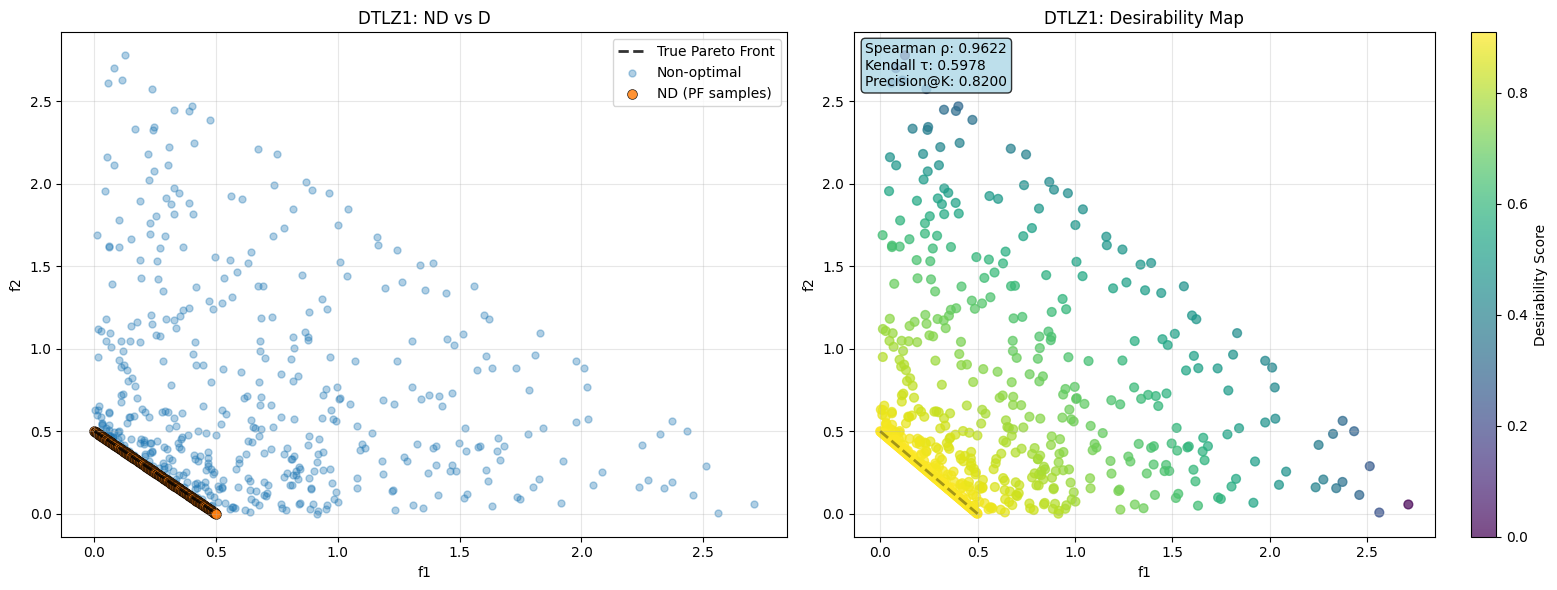


Top 10 Solutions by Desirability Score:
 Rank       f1       f2  Desirability Type
    1 0.216080 0.283920      0.908956   ND
    2 0.218593 0.281407      0.908955   ND
    3 0.213568 0.286432      0.908955   ND
    4 0.221106 0.278894      0.908954   ND
    5 0.211055 0.288945      0.908953   ND
    6 0.223618 0.276382      0.908952   ND
    7 0.208543 0.291457      0.908951   ND
    8 0.226131 0.273869      0.908949   ND
    9 0.206030 0.293970      0.908948   ND
   10 0.228643 0.271357      0.908945   ND


In [9]:
import numpy as np
import matplotlib.pyplot as plt

from spotdesirability.utils.desirability import DMin, DOverall
from scipy.spatial.distance import cdist
from scipy.stats import spearmanr, kendalltau
import pandas as pd

# =========================================================
# DTLZ1 (2 objectives): analytical Pareto front in objective space
# =========================================================
def generate_pareto_front_dtlz1_2obj(n_points=400):
    """Generate the true Pareto front for DTLZ1 with 2 objectives.

    For the DTLZ1 construction with g=0, the Pareto front satisfies:
      f1 + f2 = 0.5, with f1 >= 0 and f2 >= 0
    """
    f1 = np.linspace(0, 0.5, n_points)
    f2 = 0.5 - f1
    return f1, f2

def check_nd_correctness(F, nd_indices):
    """Verify that the provided indices form a mathematically non-dominated set."""
    ND = F[nd_indices]
    D = np.delete(F, nd_indices, axis=0)
    for a in ND:
        for b in D:
            if np.all(b <= a) and np.any(b < a):
                print("❌ WRONG ND FOUND:", a)
                return False
    print("✔ All ND points are mathematically correct.")
    return True

# =========================================================
# Dataset generation (DTLZ1, 2 objectives)
# Controlled g via fixed tail variables (x2..x5 = 0.5)
# =========================================================
def generate_dtlz1_dataset_your_sampling(
    n_nonopt=500,
    n_pareto=200,
    n_var=6,
    n_obj=2,
    seed=42,
    x1_eps=0.005  # small perturbation around 0.5 for x1 in dominated samples
):
    rng = np.random.default_rng(seed)
    assert n_var == 6 and n_obj == 2, "This script is set for DTLZ1 with n_obj=2, n_var=6."

    # ---- 1) Pareto-optimal set (g = 0): x0 varies, x1..x5 = 0.5
    X_pareto = np.zeros((n_pareto, n_var))
    X_pareto[:, 0] = np.linspace(0, 1, n_pareto)
    X_pareto[:, 1:] = 0.5

    # ---- 2) Dominated set (controlled):
    # x0 random
    # x1 close to 0.5 (tiny noise)
    # x2..x5 fixed at 0.5 -> keeps g moderate and comparable across points
    X_nonopt = np.zeros((n_nonopt, n_var))
    X_nonopt[:, 0] = rng.random(n_nonopt)
    X_nonopt[:, 1] = 0.5 + rng.uniform(-x1_eps, x1_eps, size=n_nonopt)
    X_nonopt[:, 1] = np.clip(X_nonopt[:, 1], 0.0, 1.0)
    X_nonopt[:, 2:] = 0.5

    # Evaluate
    F_nd = dtlz1(X_pareto, n_obj=n_obj)
    F_d  = dtlz1(X_nonopt, n_obj=n_obj)

    # Combine + labels
    F = np.vstack([F_nd, F_d])
    labels = np.zeros(len(F))
    labels[:n_pareto] = 1

    return F, F_nd, F_d, labels

# =========================================================
# Run
# =========================================================
n_nonopt = 500
n_pareto = 200
seed = 42
x1_eps = 0.005  # perturbation magnitude for x1 in dominated samples (±0.005)

F, nd_points, d_points, labels = generate_dtlz1_dataset_your_sampling(
    n_nonopt=n_nonopt,
    n_pareto=n_pareto,
    seed=seed,
    x1_eps=x1_eps
)

K = n_pareto
nds = np.arange(n_pareto)

print(f"✓ Total: {len(F)} points ({len(nd_points)} ND + {len(d_points)} Non-optimal)")
check_nd_correctness(F, nds)

# =========================================================
# Desirability scoring
# =========================================================
f1_min, f1_max = F[:, 0].min(), F[:, 0].max()
f2_min, f2_max = F[:, 1].min(), F[:, 1].max()

d_funcs = [DMin(f1_min, f1_max, scale=1),
           DMin(f2_min, f2_max, scale=1)]
D_scores = DOverall(*d_funcs).predict(F)
D_scores = np.maximum(D_scores, 0)

print(f"✓ Desirability scores range: [{D_scores.min():.4f}, {D_scores.max():.4f}]")

# =========================================================
# Distance-to-front correlation (Spearman)
# Dense true PF in objective space
# =========================================================
pf_f1_dense, pf_f2_dense = generate_pareto_front_dtlz1_2obj(5000)
F_pf_dense = np.column_stack([pf_f1_dense, pf_f2_dense])

dist_to_pf = np.min(cdist(F, F_pf_dense), axis=1)
rho_dist, _ = spearmanr(D_scores, -dist_to_pf)

# Kendall + Precision@K
tau, _ = kendalltau(D_scores, labels)
sorted_idx = np.argsort(-D_scores)
topK_idx = sorted_idx[:K]
precision_at_k = labels[topK_idx].sum() / K

print("="*60)
print("DESIRABILITY FUNCTION METRICS (DTLZ1, controlled sampling)")
print("="*60)
print(f"Spearman ρ (D_scores vs -dist_to_PF_dense): {rho_dist:.4f}")
print(f"Kendall τ (D_scores vs ND-labels):         {tau:.4f}")
print(f"Precision@K (K={K}):                        {precision_at_k:.4f}")
print("="*60)

# =========================================================
# Plots
# =========================================================
pf_f1, pf_f2 = generate_pareto_front_dtlz1_2obj(400)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: ND vs dominated in objective space
axes[0].plot(pf_f1, pf_f2, 'k--', linewidth=2, label='True Pareto Front', alpha=0.8)
axes[0].scatter(d_points[:, 0], d_points[:, 1], s=25, alpha=0.35, label='Non-optimal')
axes[0].scatter(nd_points[:, 0], nd_points[:, 1], s=50, alpha=0.85, label='ND (PF samples)',
                edgecolors='black', linewidth=0.5)
axes[0].set_xlabel('f1')
axes[0].set_ylabel('f2')
axes[0].set_title('DTLZ1: ND vs D')
axes[0].grid(True, alpha=0.3)
axes[0].legend()

# Plot 2: desirability heatmap in objective space
sc = axes[1].scatter(F[:, 0], F[:, 1], c=D_scores, cmap='viridis', s=40, alpha=0.7)
axes[1].plot(pf_f1, pf_f2, 'k--', linewidth=2, alpha=0.35)
axes[1].set_xlabel('f1')
axes[1].set_ylabel('f2')
axes[1].set_title('DTLZ1: Desirability Map')
axes[1].grid(True, alpha=0.3)
cbar = plt.colorbar(sc, ax=axes[1])
cbar.set_label('Desirability Score')

txt = (f"Spearman ρ: {rho_dist:.4f}\n"
       f"Kendall τ: {tau:.4f}\n"
       f"Precision@K: {precision_at_k:.4f}")
axes[1].text(0.02, 0.98, txt, transform=axes[1].transAxes,
             va='top', fontsize=10,
             bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))

plt.tight_layout()
plt.show()

# =========================================================
# Top 10 solutions
# =========================================================
top10_idx = sorted_idx[:10]
top10_data = pd.DataFrame({
    'Rank': range(1, 11),
    'f1': F[top10_idx, 0],
    'f2': F[top10_idx, 1],
    'Desirability': D_scores[top10_idx],
    'Type': ['ND' if labels[i] == 1 else 'D' for i in top10_idx]
})

print("\nTop 10 Solutions by Desirability Score:")
print(top10_data.to_string(index=False))


✓ Total: 700 points (200 ND + 500 Non-optimal)
✔ All ND points are mathematically correct.
✓ Desirability scores range: [0.0000, 0.7965]
DESIRABILITY FUNCTION METRICS (DTLZ2, 2 objectives)
Spearman ρ (D_scores vs -dist_to_PF_dense): 0.9653
Kendall τ (D_scores vs ND-labels):         0.6393
Precision@K (K=200):                        1.0000


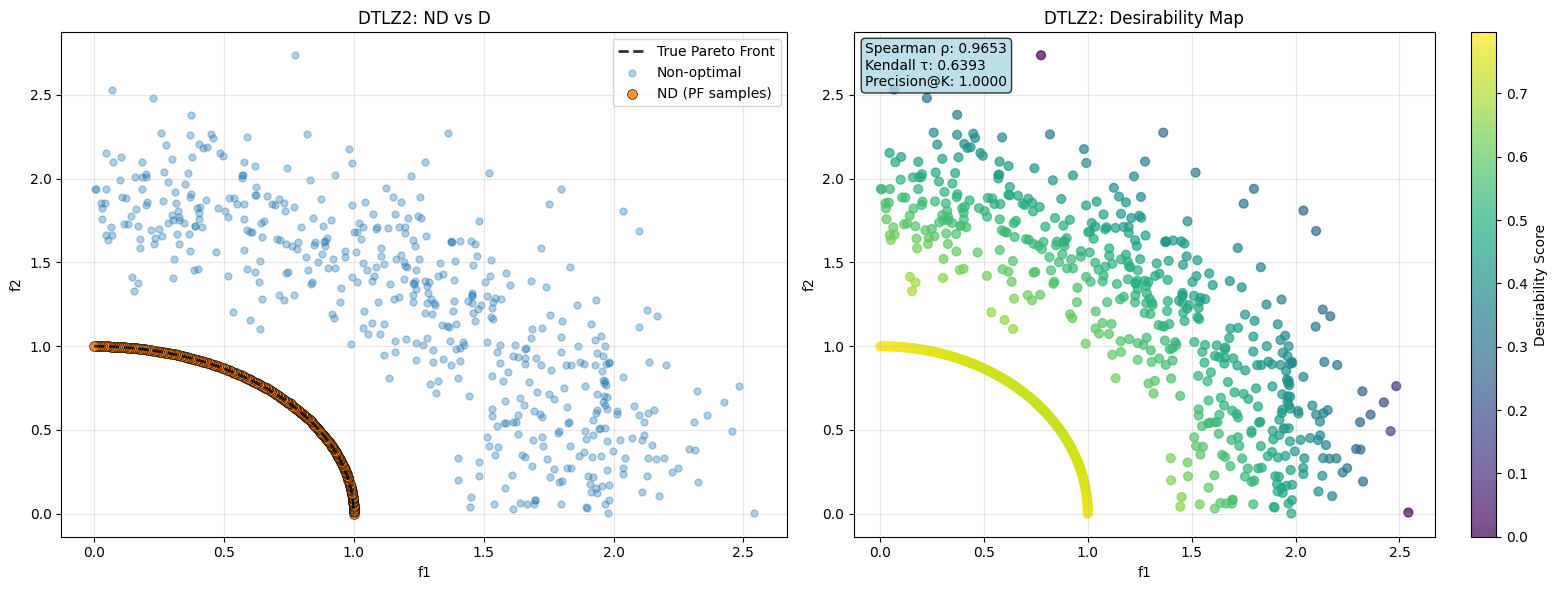


Top 10 Solutions by Desirability Score:
 Rank           f1       f2  Desirability Type
    1 6.123234e-17 1.000000      0.796547   ND
    2 7.893367e-03 0.999969      0.795317   ND
    3 1.578624e-02 0.999875      0.794099   ND
    4 2.367813e-02 0.999720      0.792894   ND
    5 3.156855e-02 0.999502      0.791701   ND
    6 3.945700e-02 0.999221      0.790520   ND
    7 4.734299e-02 0.998879      0.789352   ND
    8 5.522603e-02 0.998474      0.788196   ND
    9 6.310563e-02 0.998007      0.787053   ND
   10 7.098130e-02 0.997478      0.785922   ND


In [10]:
import numpy as np
import matplotlib.pyplot as plt

from spotdesirability.utils.desirability import DMin, DOverall
from scipy.spatial.distance import cdist
from scipy.stats import spearmanr, kendalltau
import pandas as pd

# -----------------------------
# Utilities
# -----------------------------
def generate_pareto_front_dtlz2_2obj(n_points=400):
    """Generate the true Pareto front for DTLZ2 with 2 objectives (g=0).

    For DTLZ2 with g=0 and 2 objectives, the Pareto front satisfies:
      f1^2 + f2^2 = 1,  with f1 >= 0 and f2 >= 0
    """
    f1 = np.linspace(0.0, 1.0, n_points)
    f2 = np.sqrt(np.clip(1.0 - f1**2, 0.0, 1.0))
    return f1, f2


def generate_dtlz2_dataset_professor_style_2obj(
    n_nonopt=500, n_pareto=200, n_vars=12, n_obj=2, seed=42
):
    """Create a synthetic DTLZ2 dataset with explicit ND (g=0) construction.

    ND set:
      - enforce g=0 by setting the last k variables to 0.5
      - for n_obj=2, only the first decision variable drives the PF curve shape

    Dominated set:
      - uniform random samples in [0,1]^n_vars
      - an additional shift is applied to one g-variable to avoid accidental g=0 cases
    """
    rng = np.random.default_rng(seed)

    # DTLZ2 uses: k = n_vars - n_obj + 1 (last k variables define g)
    k = n_vars - n_obj + 1
    assert k >= 1, "n_vars must be >= n_obj"

    # ---- 1) Pareto-optimal set (g=0): last k vars = 0.5
    X_pareto = np.zeros((n_pareto, n_vars))
    X_pareto[:, 0] = np.linspace(0, 1, n_pareto)        # x1 in [0,1]
    X_pareto[:, -k:] = 0.5                               # enforce g=0

    # ---- 2) Dominated set: random in [0,1]^n_vars
    X_nonopt = rng.random((n_nonopt, n_vars))

    # Reduce the chance of hitting g=0 exactly (edge-case avoidance)
    X_nonopt[:, -1] = (X_nonopt[:, -1] + 0.25) % 1.0

    # Evaluate
    F_nd = dtlz2(X_pareto, n_obj=n_obj)
    F_d  = dtlz2(X_nonopt, n_obj=n_obj)

    # Combine + labels (ND=1)
    F = np.vstack([F_nd, F_d])
    labels = np.zeros(len(F))
    labels[:n_pareto] = 1

    return F, F_nd, F_d, labels, k

# -----------------------------
# Run
# -----------------------------
n_nonopt = 500
n_pareto = 200
n_vars   = 12     # keep fixed for comparability across DTLZ2 experiments
n_obj    = 2      # 2 objectives => 2D front and 2D plots
seed     = 42

F, nd_points, d_points, labels, k = generate_dtlz2_dataset_professor_style_2obj(
    n_nonopt=n_nonopt, n_pareto=n_pareto, n_vars=n_vars, n_obj=n_obj, seed=seed
)

K = n_pareto
nds = np.arange(n_pareto)

print(f"✓ Total: {len(F)} points ({len(nd_points)} ND + {len(d_points)} Non-optimal)")
check_nd_correctness(F, nds)

# -----------------------------
# Desirability scoring
# -----------------------------
f1_min, f1_max = F[:, 0].min(), F[:, 0].max()
f2_min, f2_max = F[:, 1].min(), F[:, 1].max()

d_funcs = [DMin(f1_min, f1_max, scale=1),
           DMin(f2_min, f2_max, scale=1)]
D_scores = DOverall(*d_funcs).predict(F)
D_scores = np.maximum(D_scores, 0)

print(f"✓ Desirability scores range: [{D_scores.min():.4f}, {D_scores.max():.4f}]")

# -----------------------------
# Distance-to-front correlation (Spearman)
# Dense reference PF built from decision-space samples with g=0
# -----------------------------
n_pf_dense = 5000
X_pf_dense = np.zeros((n_pf_dense, n_vars))
X_pf_dense[:, 0] = np.linspace(0, 1, n_pf_dense)
X_pf_dense[:, -k:] = 0.5   # g=0
F_pf_dense = dtlz2(X_pf_dense, n_obj=n_obj)

dist_to_pf = np.min(cdist(F, F_pf_dense), axis=1)
rho_dist, _ = spearmanr(D_scores, -dist_to_pf)

# Kendall + Precision@K
tau, _ = kendalltau(D_scores, labels)
sorted_idx = np.argsort(-D_scores)
topK_idx = sorted_idx[:K]
precision_at_k = labels[topK_idx].sum() / K

print("="*60)
print("DESIRABILITY FUNCTION METRICS (DTLZ2, 2 objectives)")
print("="*60)
print(f"Spearman ρ (D_scores vs -dist_to_PF_dense): {rho_dist:.4f}")
print(f"Kendall τ (D_scores vs ND-labels):         {tau:.4f}")
print(f"Precision@K (K={K}):                        {precision_at_k:.4f}")
print("="*60)

# -----------------------------
# Plots
# -----------------------------
pf_f1, pf_f2 = generate_pareto_front_dtlz2_2obj(400)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: ND vs dominated in objective space (with analytical PF)
axes[0].plot(pf_f1, pf_f2, 'k--', linewidth=2, label='True Pareto Front', alpha=0.8)
axes[0].scatter(d_points[:, 0], d_points[:, 1], s=25, alpha=0.35, label='Non-optimal')
axes[0].scatter(nd_points[:, 0], nd_points[:, 1], s=50, alpha=0.85, label='ND (PF samples)',
                edgecolors='black', linewidth=0.5)
axes[0].set_xlabel('f1')
axes[0].set_ylabel('f2')
axes[0].set_title('DTLZ2: ND vs D')
axes[0].grid(True, alpha=0.3)
axes[0].legend()

# Plot 2: desirability map in objective space
sc = axes[1].scatter(F[:, 0], F[:, 1], c=D_scores, cmap='viridis', s=40, alpha=0.7)
axes[1].set_xlabel('f1')
axes[1].set_ylabel('f2')
axes[1].set_title('DTLZ2: Desirability Map')
axes[1].grid(True, alpha=0.3)
cbar = plt.colorbar(sc, ax=axes[1])
cbar.set_label('Desirability Score')

txt = (f"Spearman ρ: {rho_dist:.4f}\n"
       f"Kendall τ: {tau:.4f}\n"
       f"Precision@K: {precision_at_k:.4f}")
axes[1].text(0.02, 0.98, txt, transform=axes[1].transAxes,
             va='top', fontsize=10,
             bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))

plt.tight_layout()
plt.show()

# -----------------------------
# Top 10 solutions
# -----------------------------
top10_idx = sorted_idx[:10]
top10_data = pd.DataFrame({
    'Rank': range(1, 11),
    'f1': F[top10_idx, 0],
    'f2': F[top10_idx, 1],
    'Desirability': D_scores[top10_idx],
    'Type': ['ND' if labels[i] == 1 else 'D' for i in top10_idx]
})
print("\nTop 10 Solutions by Desirability Score:")
print(top10_data.to_string(index=False))


✓ Total: 700 points (200 ND + 500 Non-optimal)
✔ All ND points are mathematically correct.
✓ PF radius mean: 1.000000 (expected ~1.0)
✓ Desirability scores range: [0.0000, 0.6959]
DESIRABILITY FUNCTION METRICS (DTLZ3, single-band sampling)
Spearman ρ (D_scores vs -dist_to_PF_dense): 0.9708
Kendall τ (D_scores vs ND-labels):         0.6325
Precision@K (K=200):                        0.9700


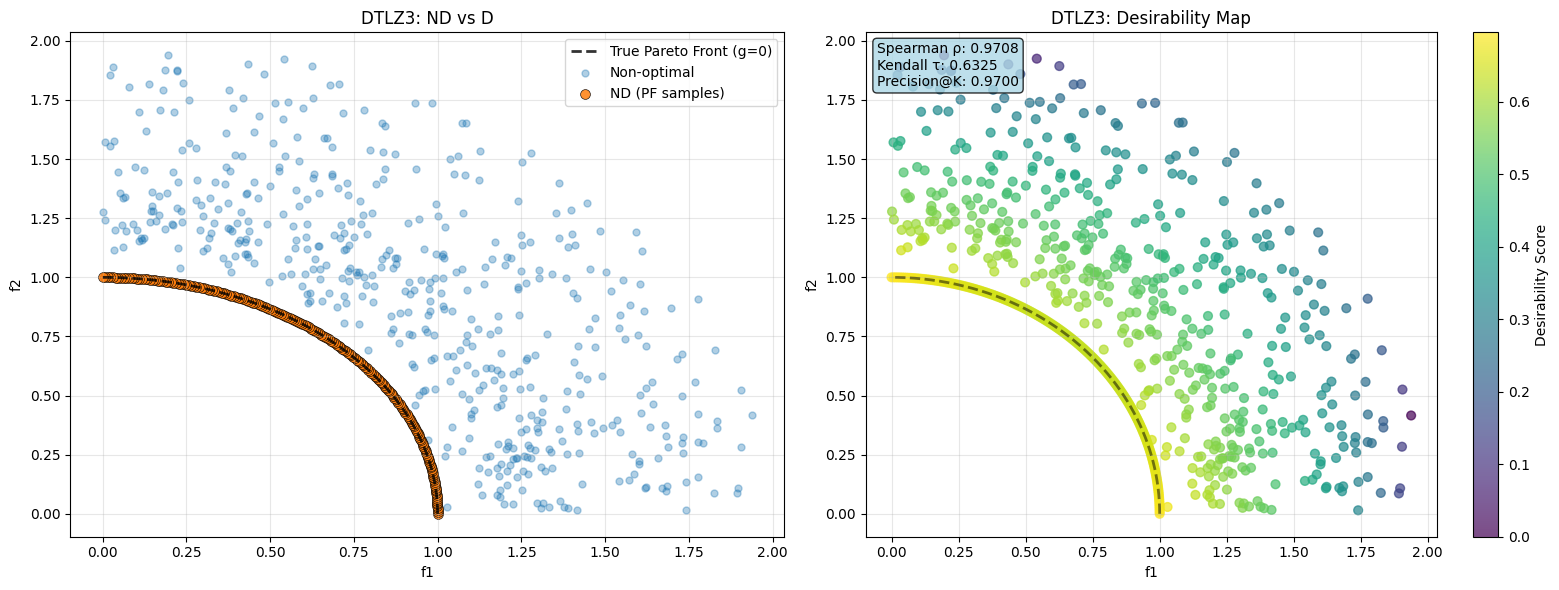


Top 10 Solutions by Desirability Score:
 Rank           f1       f2  Desirability Type
    1 6.123234e-17 1.000000      0.695925   ND
    2 1.000000e+00 0.000000      0.695682   ND
    3 7.893367e-03 0.999969      0.694518   ND
    4 9.999688e-01 0.007893      0.694276   ND
    5 1.578624e-02 0.999875      0.693131   ND
    6 9.998754e-01 0.015786      0.692890   ND
    7 2.367813e-02 0.999720      0.691764   ND
    8 9.997196e-01 0.023678      0.691525   ND
    9 3.156855e-02 0.999502      0.690417   ND
   10 9.995016e-01 0.031569      0.690179   ND


In [11]:
import numpy as np
import matplotlib.pyplot as plt

from spotdesirability.utils.desirability import DMin, DOverall
from scipy.spatial.distance import cdist
from scipy.stats import spearmanr, kendalltau
import pandas as pd

# =========================================================
# DTLZ3 (2 objectives): analytical Pareto front in objective space (g=0)
# =========================================================
def generate_pareto_front_dtlz3_2obj(n_points=400):
    """Generate the true Pareto front for DTLZ3 with 2 objectives (g=0).

    For DTLZ3 with g=0 and 2 objectives, the Pareto front is the quarter-circle:
      f1 = cos(theta), f2 = sin(theta), theta ∈ [0, pi/2]
    """
    theta = np.linspace(0, np.pi / 2, n_points)
    f1 = np.cos(theta)
    f2 = np.sin(theta)
    return f1, f2

def check_nd_correctness(F, nd_indices):
    """Verify that the provided indices form a mathematically non-dominated set."""
    ND = F[nd_indices]
    D = np.delete(F, nd_indices, axis=0)
    for a in ND:
        for b in D:
            if np.all(b <= a) and np.any(b < a):
                print("❌ WRONG ND FOUND:", a)
                return False
    print("✔ All ND points are mathematically correct.")
    return True

# =========================================================
# Dataset generation (DTLZ3, 2 objectives)
# Strategy: PF injection + single-band dominated cloud (radius filtering)
# =========================================================
def generate_dtlz3_dataset_single_band(
    n_nonopt=500,
    n_pareto=200,
    n_obj=2,
    n_var=6,
    seed=42,
    delta=0.01,
    r_max=2.0,
    x1_band=8e-4,
    sigma_hidden=8e-4,
    n_cand=25000,
    max_tries=12,
):
    rng = np.random.default_rng(seed)

    # 1) PF injected (g=0): x0 varies, remaining variables set to 0.5
    x0_pf = np.linspace(0, 1, n_pareto)
    X_pareto_full = np.zeros((n_pareto, n_var))
    X_pareto_full[:, 0] = x0_pf
    X_pareto_full[:, 1:] = 0.5
    F_nd = dtlz3(X_pareto_full, n_obj=n_obj)

    # 2) Dominated set: generate a smooth cloud near the PF but slightly outside
    # using a radius band in objective space (r > 1 + delta) with an upper cutoff (r < r_max)
    kept_X = []
    kept_F = []

    need = n_nonopt
    for _ in range(max_tries):
        X = np.zeros((n_cand, n_var))
        X[:, 0] = rng.random(n_cand)  # x0 free

        # Small perturbations around 0.5 for variables that influence g
        X[:, 1] = 0.5 + rng.uniform(-x1_band, x1_band, size=n_cand)
        X[:, 2:] = 0.5 + rng.normal(0.0, sigma_hidden, size=(n_cand, n_var - 2))
        X[:, 1:] = np.clip(X[:, 1:], 0.0, 1.0)

        F = dtlz3(X, n_obj=n_obj)
        r = np.sqrt(F[:, 0] ** 2 + F[:, 1] ** 2)

        # Radius band: slightly outside PF, not too far
        mask = (r > 1.0 + delta) & (r < r_max)

        # Safety filter: ensure points are dominated by the corresponding PF point
        # obtained at the same angle theta in objective space
        if np.any(mask):
            Fm = F[mask]
            theta = np.arctan2(Fm[:, 1], Fm[:, 0])
            pf = np.column_stack([np.cos(theta), np.sin(theta)])
            dom = np.all(pf <= Fm + 1e-12, axis=1) & np.any(pf < Fm - 1e-12, axis=1)

            if np.any(dom):
                kept_X.append(X[mask][dom])
                kept_F.append(Fm[dom])

        if sum(a.shape[0] for a in kept_X) >= need:
            break

    if len(kept_X) == 0:
        raise RuntimeError(
            "No non-optimal points were accepted. Try smaller x1_band/sigma_hidden "
            "(e.g., 5e-4), or reduce delta (e.g., 0.005), or increase r_max (e.g., 3.0)."
        )

    X_nonopt_full = np.vstack(kept_X)[:need]
    F_d = np.vstack(kept_F)[:need]

    # Combine + labels (ND first)
    F = np.vstack([F_nd, F_d])
    labels = np.zeros(len(F))
    labels[:n_pareto] = 1

    return F, F_nd, F_d, labels, X_pareto_full, X_nonopt_full

# =========================================================
# Run
# =========================================================
n_nonopt = 500
n_pareto = 200
n_obj = 2
n_var = 6
seed = 42

F, nd_points, d_points, labels, X_pareto_full, X_nonopt_full = generate_dtlz3_dataset_single_band(
    n_nonopt=n_nonopt,
    n_pareto=n_pareto,
    n_obj=n_obj,
    n_var=n_var,
    seed=seed,
    delta=0.01,
    r_max=2.0,
    x1_band=8e-4,
    sigma_hidden=8e-4,
)

K = n_pareto
nds = np.arange(n_pareto)

print(f"✓ Total: {len(F)} points ({len(nd_points)} ND + {len(d_points)} Non-optimal)")
check_nd_correctness(F, nds)

# Quick PF check: radius ~ 1 for injected PF points
r_pf = np.sqrt(nd_points[:, 0] ** 2 + nd_points[:, 1] ** 2)
print(f"✓ PF radius mean: {r_pf.mean():.6f} (expected ~1.0)")

# =========================================================
# Desirability scoring
# =========================================================
f1_min, f1_max = F[:, 0].min(), F[:, 0].max()
f2_min, f2_max = F[:, 1].min(), F[:, 1].max()

d_funcs = [DMin(f1_min, f1_max, scale=1), DMin(f2_min, f2_max, scale=1)]
D_scores = DOverall(*d_funcs).predict(F)
D_scores = np.maximum(D_scores, 0)

print(f"✓ Desirability scores range: [{D_scores.min():.4f}, {D_scores.max():.4f}]")

# =========================================================
# Distance-to-front correlation (Spearman)
# Dense PF constructed in decision space with g=0
# =========================================================
n_pf_dense = 5000
X_pf_dense = np.zeros((n_pf_dense, n_var))
X_pf_dense[:, 0] = np.linspace(0, 1, n_pf_dense)
X_pf_dense[:, 1:] = 0.5
F_pf_dense = dtlz3(X_pf_dense, n_obj=n_obj)

dist_to_pf = np.min(cdist(F, F_pf_dense), axis=1)
rho_dist, _ = spearmanr(D_scores, -dist_to_pf)

tau, _ = kendalltau(D_scores, labels)
sorted_idx = np.argsort(-D_scores)
topK_idx = sorted_idx[:K]
precision_at_k = labels[topK_idx].sum() / K

print("=" * 60)
print("DESIRABILITY FUNCTION METRICS (DTLZ3, single-band sampling)")
print("=" * 60)
print(f"Spearman ρ (D_scores vs -dist_to_PF_dense): {rho_dist:.4f}")
print(f"Kendall τ (D_scores vs ND-labels):         {tau:.4f}")
print(f"Precision@K (K={K}):                        {precision_at_k:.4f}")
print("=" * 60)

# =========================================================
# Plots
# =========================================================
pf_f1, pf_f2 = generate_pareto_front_dtlz3_2obj(400)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

axes[0].plot(pf_f1, pf_f2, "k--", linewidth=2, label="True Pareto Front (g=0)", alpha=0.8)
axes[0].scatter(d_points[:, 0], d_points[:, 1], s=25, alpha=0.35, label="Non-optimal")
axes[0].scatter(
    nd_points[:, 0],
    nd_points[:, 1],
    s=50,
    alpha=0.85,
    label="ND (PF samples)",
    edgecolors="black",
    linewidth=0.5,
)
axes[0].set_xlabel("f1")
axes[0].set_ylabel("f2")
axes[0].set_title("DTLZ3: ND vs D")
axes[0].grid(True, alpha=0.3)
axes[0].legend()

sc = axes[1].scatter(F[:, 0], F[:, 1], c=D_scores, cmap="viridis", s=40, alpha=0.7)
axes[1].plot(pf_f1, pf_f2, "k--", linewidth=2, alpha=0.5)
axes[1].set_xlabel("f1")
axes[1].set_ylabel("f2")
axes[1].set_title("DTLZ3: Desirability Map")
axes[1].grid(True, alpha=0.3)
cbar = plt.colorbar(sc, ax=axes[1])
cbar.set_label("Desirability Score")

txt = f"Spearman ρ: {rho_dist:.4f}\nKendall τ: {tau:.4f}\nPrecision@K: {precision_at_k:.4f}"
axes[1].text(
    0.02,
    0.98,
    txt,
    transform=axes[1].transAxes,
    va="top",
    fontsize=10,
    bbox=dict(boxstyle="round", facecolor="lightblue", alpha=0.8),
)

plt.tight_layout()
plt.show()

# =========================================================
# Top 10 solutions
# =========================================================
top10_idx = sorted_idx[:10]
top10_data = pd.DataFrame(
    {
        "Rank": range(1, 11),
        "f1": F[top10_idx, 0],
        "f2": F[top10_idx, 1],
        "Desirability": D_scores[top10_idx],
        "Type": ["ND" if labels[i] == 1 else "D" for i in top10_idx],
    }
)

print("\nTop 10 Solutions by Desirability Score:")
print(top10_data.to_string(index=False))


✓ Total: 1100 points (600 ND + 500 Non-optimal)
✔ All ND points are mathematically correct.
✓ Desirability scores range: [0.0000, 0.3754]
DESIRABILITY FUNCTION METRICS (DTLZ4, alpha=100)
Spearman ρ (D_scores vs -dist_to_PF_dense): 0.9068
Kendall τ (D_scores vs ND-labels):         0.7180
Precision@K (K=600):                        0.9783
✓ PF radius mean: 1.000000 (expected ~1.0)
  PF radius range: [1.000000, 1.000000]


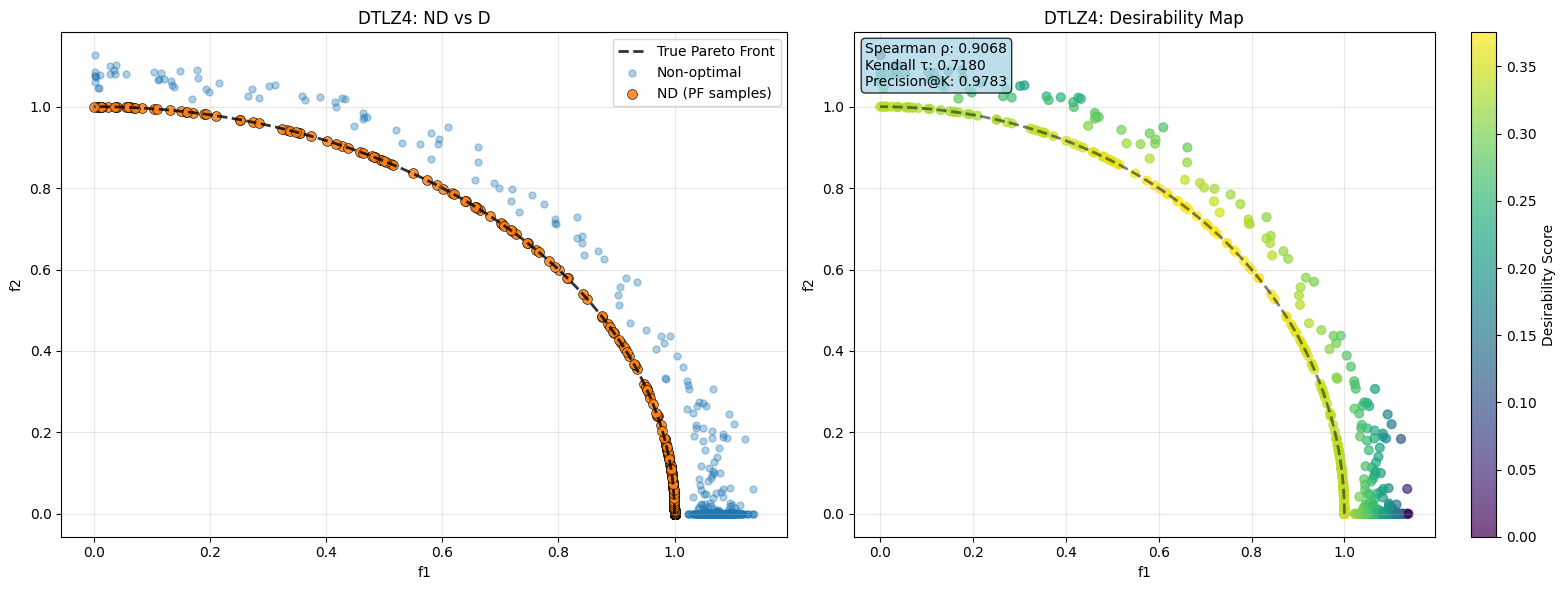


Top 10 Solutions by Desirability Score:
 Rank       f1       f2  Desirability Type
    1 0.720511 0.693444      0.375416   ND
    2 0.718064 0.695977      0.375411   ND
    3 0.726686 0.686970      0.375404   ND
    4 0.706371 0.707842      0.375320   ND
    5 0.702187 0.711992      0.375260   ND
    6 0.700577 0.713577      0.375234   ND
    7 0.746566 0.665311      0.375135   ND
    8 0.747353 0.664428      0.375117   ND
    9 0.681631 0.731696      0.374768   ND
   10 0.761634 0.648008      0.374681   ND


In [12]:
import numpy as np
import matplotlib.pyplot as plt

from spotdesirability.utils.desirability import DMin, DOverall
from scipy.spatial.distance import cdist
from scipy.stats import spearmanr, kendalltau
import pandas as pd

# ============================================================
# DTLZ4 (2 objectives): analytical Pareto front in objective space (g=0)
# ============================================================
def generate_pareto_front_dtlz4_2obj(n_points=400):
    """Generate the true Pareto front for DTLZ4 with 2 objectives (g=0).

    For DTLZ4, the Pareto front geometry (in objective space) matches DTLZ2 when g=0:
      f1^2 + f2^2 = 1, with f1 >= 0 and f2 >= 0  (quarter unit circle)
    """
    theta = np.linspace(0, np.pi / 2, n_points)
    f1 = np.cos(theta)
    f2 = np.sin(theta)
    return f1, f2

def check_nd_correctness(F, nd_indices):
    """Verify that the provided indices form a mathematically non-dominated set."""
    ND = F[nd_indices]
    D = np.delete(F, nd_indices, axis=0)
    for a in ND:
        for b in D:
            if np.all(b <= a) and np.any(b < a):
                print("❌ WRONG ND FOUND:", a)
                return False
    print("✔ All ND points are mathematically correct.")
    return True

# -----------------------------
# Dataset generation (DTLZ4, 2 objectives)
# Biased sampling to reflect the alpha effect in decision space
# -----------------------------
def generate_dtlz4_dataset_biased_sampling(
    n_nonopt=300, n_pareto=500, n_vars=11, alpha=100, seed=42
):
    rng = np.random.default_rng(seed)

    # ---- 1) Pareto set (g=0): x1..x10 = 0.5, sample x0 with emphasis near extremes
    # This sampling is designed to produce a more informative spread under strong bias (alpha=100).
    x0_low = rng.beta(0.5, 2, size=n_pareto // 2)
    x0_high = 1 - rng.beta(0.5, 8, size=n_pareto // 2)
    x0_uniform = np.linspace(0.8, 1.0, 100)

    x0_pf = np.concatenate([x0_low, x0_high, x0_uniform])
    x0_pf = np.clip(x0_pf, 0.0, 1.0)
    n_pareto_eff = len(x0_pf)

    X_pareto = np.zeros((n_pareto_eff, n_vars))
    X_pareto[:, 0] = x0_pf
    X_pareto[:, 1:] = 0.5  # enforce g=0

    F_nd = dtlz4(X_pareto, n_obj=2, alpha=alpha)

    # ---- 2) Dominated set: similar x0 distribution, but perturb g-variables around 0.5
    # The perturbation increases g above 0 while keeping it moderate.
    X_nonopt = np.zeros((n_nonopt, n_vars))

    x0_nonopt_low = rng.beta(0.5, 2, size=n_nonopt // 2)
    x0_nonopt_high = 1 - rng.beta(0.5, 8, size=n_nonopt - n_nonopt // 2)
    X_nonopt[:, 0] = np.concatenate([x0_nonopt_low, x0_nonopt_high])
    X_nonopt[:, 0] = np.clip(X_nonopt[:, 0], 0.0, 1.0)

    X_nonopt[:, 1:] = 0.5 + 0.3 * (rng.random((n_nonopt, n_vars - 1)) - 0.5)
    X_nonopt[:, 1:] = np.clip(X_nonopt[:, 1:], 0.0, 1.0)

    F_d = dtlz4(X_nonopt, n_obj=2, alpha=alpha)

    # ---- 3) Combine + labels
    F = np.vstack([F_nd, F_d])
    labels = np.zeros(len(F))
    labels[:n_pareto_eff] = 1  # PF samples labeled as ND

    return F, F_nd, F_d, labels, X_pareto, X_nonopt

# -----------------------------
# Run
# -----------------------------
n_nonopt = 500
n_pareto = 500
n_vars = 11
alpha = 100
seed = 42

F, nd_points, d_points, labels, X_pareto, X_nonopt = generate_dtlz4_dataset_biased_sampling(
    n_nonopt=n_nonopt, n_pareto=n_pareto, n_vars=n_vars, alpha=alpha, seed=seed
)

K = len(nd_points)
nds = np.arange(len(nd_points))

print(f"✓ Total: {len(F)} points ({len(nd_points)} ND + {len(d_points)} Non-optimal)")
check_nd_correctness(F, nds)

# -----------------------------
# Desirability scoring
# -----------------------------
f1_min, f1_max = F[:, 0].min(), F[:, 0].max()
f2_min, f2_max = F[:, 1].min(), F[:, 1].max()

d_funcs = [DMin(f1_min, f1_max, scale=1),
           DMin(f2_min, f2_max, scale=1)]
D_scores = DOverall(*d_funcs).predict(F)
D_scores = np.maximum(D_scores, 0)

print(f"✓ Desirability scores range: [{D_scores.min():.4f}, {D_scores.max():.4f}]")

# -----------------------------
# Distance-to-front correlation (Spearman)
# Dense PF generated directly in objective space
# -----------------------------
pf_f1_dense, pf_f2_dense = generate_pareto_front_dtlz4_2obj(5000)
F_pf_dense = np.column_stack([pf_f1_dense, pf_f2_dense])

dist_to_pf = np.min(cdist(F, F_pf_dense), axis=1)
rho_dist, _ = spearmanr(D_scores, -dist_to_pf)

# Kendall + Precision@K
tau, _ = kendalltau(D_scores, labels)
sorted_idx = np.argsort(-D_scores)
topK_idx = sorted_idx[:K]
precision_at_k = labels[topK_idx].sum() / K

print("=" * 60)
print("DESIRABILITY FUNCTION METRICS (DTLZ4, alpha=100)")
print("=" * 60)
print(f"Spearman ρ (D_scores vs -dist_to_PF_dense): {rho_dist:.4f}")
print(f"Kendall τ (D_scores vs ND-labels):         {tau:.4f}")
print(f"Precision@K (K={K}):                        {precision_at_k:.4f}")
print("=" * 60)

# -----------------------------
# Sanity checks (PF geometry)
# -----------------------------
r_pf = np.sqrt(nd_points[:, 0] ** 2 + nd_points[:, 1] ** 2)
print(f"✓ PF radius mean: {r_pf.mean():.6f} (expected ~1.0)")
print(f"  PF radius range: [{r_pf.min():.6f}, {r_pf.max():.6f}]")

# -----------------------------
# Plots
# -----------------------------
pf_f1, pf_f2 = generate_pareto_front_dtlz4_2obj(400)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: ND vs dominated + true PF
axes[0].plot(pf_f1, pf_f2, 'k--', linewidth=2, label='True Pareto Front', alpha=0.8)
axes[0].scatter(d_points[:, 0], d_points[:, 1], s=25, alpha=0.35, label='Non-optimal')
axes[0].scatter(nd_points[:, 0], nd_points[:, 1], s=50, alpha=0.85, label='ND (PF samples)',
                edgecolors='black', linewidth=0.5)
axes[0].set_xlabel('f1')
axes[0].set_ylabel('f2')
axes[0].set_title('DTLZ4: ND vs D')
axes[0].grid(True, alpha=0.3)
axes[0].legend()

# Plot 2: desirability map
sc = axes[1].scatter(F[:, 0], F[:, 1], c=D_scores, cmap='viridis', s=40, alpha=0.7)
axes[1].plot(pf_f1, pf_f2, 'k--', linewidth=2, alpha=0.5)
axes[1].set_xlabel('f1')
axes[1].set_ylabel('f2')
axes[1].set_title('DTLZ4: Desirability Map')
axes[1].grid(True, alpha=0.3)
cbar = plt.colorbar(sc, ax=axes[1])
cbar.set_label('Desirability Score')

txt = (f"Spearman ρ: {rho_dist:.4f}\n"
       f"Kendall τ: {tau:.4f}\n"
       f"Precision@K: {precision_at_k:.4f}")
axes[1].text(0.02, 0.98, txt, transform=axes[1].transAxes,
             va='top', fontsize=10,
             bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))

plt.tight_layout()
plt.show()

# -----------------------------
# Top 10 solutions
# -----------------------------
top10_idx = sorted_idx[:10]
top10_data = pd.DataFrame({
    'Rank': range(1, 11),
    'f1': F[top10_idx, 0],
    'f2': F[top10_idx, 1],
    'Desirability': D_scores[top10_idx],
    'Type': ['ND' if labels[i] == 1 else 'D' for i in top10_idx]
})
print("\nTop 10 Solutions by Desirability Score:")
print(top10_data.to_string(index=False))


✓ Total: 500 points (250 ND + 250 Non-optimal kept)
✔ All ND points are mathematically correct.
✓ Desirability scores range: [0.0000, 0.3675]
DESIRABILITY FUNCTION METRICS (DTLZ5, controlled sampling)
Spearman ρ (D_scores vs -dist_to_PF_dense): 0.7459
Kendall τ (D_scores vs ND-labels):         0.6332
Precision@K (K=250):                        0.8400
✓ PF radius mean: 1.000000 (expected ~1.0)
  PF radius range: [1.000000, 1.000000]
  Non-opt radius range: [1.019883, 1.136474] (cap=1.2)


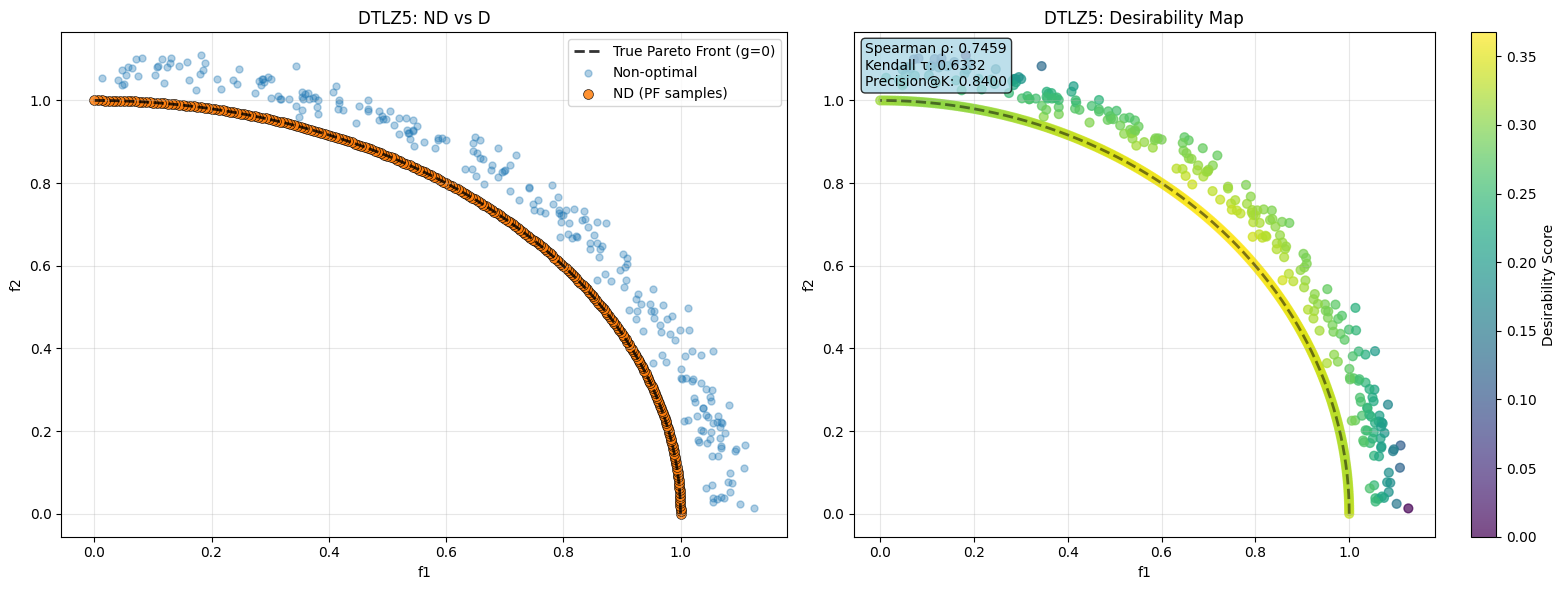


Top 10 Solutions by Desirability Score:
 Rank       f1       f2  Desirability Type
    1 0.726892 0.686751      0.367473   ND
    2 0.722546 0.691323      0.367464   ND
    3 0.731210 0.682152      0.367463   ND
    4 0.718170 0.695867      0.367437   ND
    5 0.735499 0.677526      0.367436   ND
    6 0.713766 0.700384      0.367392   ND
    7 0.739758 0.672873      0.367391   ND
    8 0.709334 0.704873      0.367328   ND
    9 0.743988 0.668192      0.367328   ND
   10 0.748189 0.663486      0.367247   ND


In [13]:
import numpy as np
import matplotlib.pyplot as plt

from spotdesirability.utils.desirability import DMin, DOverall
from scipy.spatial.distance import cdist
from scipy.stats import spearmanr, kendalltau
import pandas as pd

# ============================================================
# DTLZ5 (2 objectives): analytical Pareto front in objective space (g=0)
# ============================================================
def generate_pareto_front_dtlz5_2obj(n_points=400):
    """Generate the true Pareto front for DTLZ5 with 2 objectives (g=0).

    For the 2-objective configuration, the DTLZ5 front in objective space is
    the same quarter unit circle as DTLZ2 when g=0:
      f1 = cos(theta), f2 = sin(theta), theta ∈ [0, pi/2]
    """
    theta = np.linspace(0, np.pi / 2, n_points)
    f1 = np.cos(theta)
    f2 = np.sin(theta)
    return f1, f2

def check_nd_correctness(F, nd_indices):
    """Verify that the provided indices form a mathematically non-dominated set."""
    ND = F[nd_indices]
    D = np.delete(F, nd_indices, axis=0)
    for a in ND:
        for b in D:
            if np.all(b <= a) and np.any(b < a):
                print("❌ WRONG ND FOUND:", a)
                return False
    print("✔ All ND points are mathematically correct.")
    return True

# -----------------------------
# Dataset generation (DTLZ5, 2 objectives)
# Strategy: PF injection + moderate perturbations + radius filtering
# -----------------------------
def generate_dtlz5_dataset_your_sampling(
    n_pareto=250,
    n_nonopt=250,
    n_vars=11,
    radius_cap=1.2,
    seed=42
):
    rng = np.random.default_rng(seed)

    # Pareto-optimal set (g=0): x0 varies, x1.. = 0.5
    x0_pf = np.linspace(0, 1, n_pareto)
    X_pareto = np.column_stack([x0_pf.reshape(-1, 1), np.full((n_pareto, n_vars - 1), 0.5)])
    F_nd = dtlz5(X_pareto, n_obj=2)

    # Dominated candidates: perturb hidden variables around 0.5 to increase g
    X_nonopt = np.zeros((n_nonopt, n_vars))
    X_nonopt[:, 0] = rng.random(n_nonopt)
    X_nonopt[:, 1:] = 0.5 + 0.3 * (rng.random((n_nonopt, n_vars - 1)) - 0.5)  # ~[0.35, 0.65]
    X_nonopt[:, 1:] = np.clip(X_nonopt[:, 1:], 0.0, 1.0)
    F_d_all = dtlz5(X_nonopt, n_obj=2)

    # Filter dominated points by objective-space radius to keep scale comparable
    r_nonopt = np.sqrt(F_d_all[:, 0] ** 2 + F_d_all[:, 1] ** 2)
    keep = r_nonopt < radius_cap

    X_nonopt_kept = X_nonopt[keep]
    F_d = F_d_all[keep]

    # Combine (keep PF first)
    F = np.vstack([F_nd, F_d])
    labels = np.zeros(len(F))
    labels[:n_pareto] = 1

    return F, F_nd, F_d, labels, X_pareto, X_nonopt_kept

# -----------------------------
# Run
# -----------------------------
n_pareto = 250
n_nonopt = 250
n_vars = 11
radius_cap = 1.2
seed = 42

F, nd_points, d_points, labels, X_pareto, X_nonopt = generate_dtlz5_dataset_your_sampling(
    n_pareto=n_pareto,
    n_nonopt=n_nonopt,
    n_vars=n_vars,
    radius_cap=radius_cap,
    seed=seed
)

K = n_pareto
nds = np.arange(n_pareto)

print(f"✓ Total: {len(F)} points ({len(nd_points)} ND + {len(d_points)} Non-optimal kept)")
check_nd_correctness(F, nds)

# -----------------------------
# Desirability scoring
# -----------------------------
f1_min, f1_max = F[:, 0].min(), F[:, 0].max()
f2_min, f2_max = F[:, 1].min(), F[:, 1].max()

d_funcs = [
    DMin(f1_min, f1_max, scale=1),
    DMin(f2_min, f2_max, scale=1),
]
D_scores = DOverall(*d_funcs).predict(F)
D_scores = np.maximum(D_scores, 0)

print(f"✓ Desirability scores range: [{D_scores.min():.4f}, {D_scores.max():.4f}]")

# -----------------------------
# Distance-to-front correlation (Spearman)
# Dense PF generated in objective space
# -----------------------------
pf_f1_dense, pf_f2_dense = generate_pareto_front_dtlz5_2obj(5000)
F_pf_dense = np.column_stack([pf_f1_dense, pf_f2_dense])

dist_to_pf = np.min(cdist(F, F_pf_dense), axis=1)
rho_dist, _ = spearmanr(D_scores, -dist_to_pf)

# Kendall + Precision@K
tau, _ = kendalltau(D_scores, labels)
sorted_idx = np.argsort(-D_scores)
topK_idx = sorted_idx[:K]
precision_at_k = labels[topK_idx].sum() / K

print("=" * 60)
print("DESIRABILITY FUNCTION METRICS (DTLZ5, controlled sampling)")
print("=" * 60)
print(f"Spearman ρ (D_scores vs -dist_to_PF_dense): {rho_dist:.4f}")
print(f"Kendall τ (D_scores vs ND-labels):         {tau:.4f}")
print(f"Precision@K (K={K}):                        {precision_at_k:.4f}")
print("=" * 60)

# -----------------------------
# Sanity checks (radius)
# -----------------------------
r_pf = np.sqrt(nd_points[:, 0] ** 2 + nd_points[:, 1] ** 2)
print(f"✓ PF radius mean: {r_pf.mean():.6f} (expected ~1.0)")
print(f"  PF radius range: [{r_pf.min():.6f}, {r_pf.max():.6f}]")

if len(d_points) > 0:
    r_non = np.sqrt(d_points[:, 0] ** 2 + d_points[:, 1] ** 2)
    print(f"  Non-opt radius range: [{r_non.min():.6f}, {r_non.max():.6f}] (cap={radius_cap})")

# -----------------------------
# Plots
# -----------------------------
pf_f1, pf_f2 = generate_pareto_front_dtlz5_2obj(400)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

axes[0].plot(pf_f1, pf_f2, 'k--', linewidth=2, label='True Pareto Front (g=0)', alpha=0.8)
axes[0].scatter(d_points[:, 0], d_points[:, 1], s=25, alpha=0.35, label='Non-optimal')
axes[0].scatter(nd_points[:, 0], nd_points[:, 1], s=50, alpha=0.85, label='ND (PF samples)',
                edgecolors='black', linewidth=0.5)
axes[0].set_xlabel('f1')
axes[0].set_ylabel('f2')
axes[0].set_title('DTLZ5: ND vs D')
axes[0].grid(True, alpha=0.3)
axes[0].legend()

sc = axes[1].scatter(F[:, 0], F[:, 1], c=D_scores, cmap='viridis', s=40, alpha=0.7)
axes[1].plot(pf_f1, pf_f2, 'k--', linewidth=2, alpha=0.5)
axes[1].set_xlabel('f1')
axes[1].set_ylabel('f2')
axes[1].set_title('DTLZ5: Desirability Map')
axes[1].grid(True, alpha=0.3)
cbar = plt.colorbar(sc, ax=axes[1])
cbar.set_label('Desirability Score')

txt = (f"Spearman ρ: {rho_dist:.4f}\n"
       f"Kendall τ: {tau:.4f}\n"
       f"Precision@K: {precision_at_k:.4f}")
axes[1].text(0.02, 0.98, txt, transform=axes[1].transAxes,
             va='top', fontsize=10,
             bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))

plt.tight_layout()
plt.show()

# -----------------------------
# Top 10 solutions
# -----------------------------
top10_idx = sorted_idx[:10]
top10_data = pd.DataFrame({
    'Rank': range(1, 11),
    'f1': F[top10_idx, 0],
    'f2': F[top10_idx, 1],
    'Desirability': D_scores[top10_idx],
    'Type': ['ND' if labels[i] == 1 else 'D' for i in top10_idx]
})
print("\nTop 10 Solutions by Desirability Score:")
print(top10_data.to_string(index=False))


✓ Total: 450 points (200 ND + 250 Non-optimal)
✔ All ND points are mathematically correct.
✓ Desirability scores range: [0.0000, 0.5437]
DESIRABILITY FUNCTION METRICS (DTLZ6, single-band sampling)
Spearman ρ (D_scores vs -dist_to_PF_dense): 0.9059
Kendall τ (D_scores vs ND-labels):         0.6982
Precision@K (K=200):                        0.9850
✓ PF radius mean: 1.000000 (expected ~1.0)
  PF radius range: [1.000000, 1.000000]


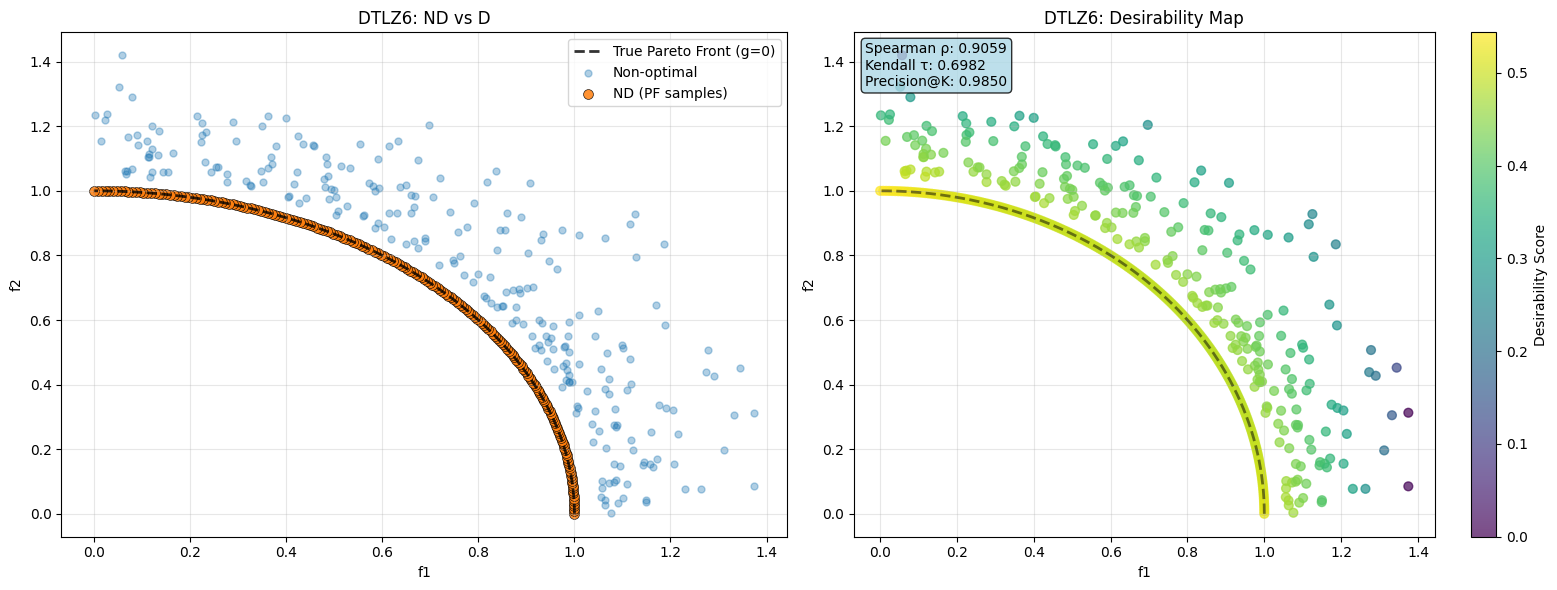


Top 10 Solutions by Desirability Score:
 Rank           f1       f2  Desirability Type
    1 6.123234e-17 1.000000      0.543725   ND
    2 7.893367e-03 0.999969      0.542183   ND
    3 1.578624e-02 0.999875      0.540675   ND
    4 2.367813e-02 0.999720      0.539203   ND
    5 3.156855e-02 0.999502      0.537766   ND
    6 3.945700e-02 0.999221      0.536364   ND
    7 4.734299e-02 0.998879      0.534996   ND
    8 5.522603e-02 0.998474      0.533662   ND
    9 6.310563e-02 0.998007      0.532361   ND
   10 7.098130e-02 0.997478      0.531094   ND


In [14]:
import numpy as np
import matplotlib.pyplot as plt

from spotdesirability.utils.desirability import DMin, DOverall
from scipy.spatial.distance import cdist
from scipy.stats import spearmanr, kendalltau
import pandas as pd

# ============================================================
# DTLZ6 (2 objectives): analytical Pareto front in objective space (g=0)
# ============================================================
def generate_pareto_front_dtlz6_2obj(n_points=400):
    """Generate the true Pareto front for DTLZ6 with 2 objectives (g=0).

    With 2 objectives, the g=0 front in objective space follows the same
    quarter unit circle parameterization:
      f1 = cos(theta), f2 = sin(theta), theta ∈ [0, pi/2]
    """
    theta = np.linspace(0, np.pi / 2, n_points)
    f1 = np.cos(theta)
    f2 = np.sin(theta)
    return f1, f2

def check_nd_correctness(F, nd_indices):
    """Verify that the provided indices form a mathematically non-dominated set."""
    ND = F[nd_indices]
    D = np.delete(F, nd_indices, axis=0)
    for a in ND:
        for b in D:
            if np.all(b <= a) and np.any(b < a):
                print("❌ WRONG ND FOUND:", a)
                return False
    print("✔ All ND points are mathematically correct.")
    return True

# -----------------------------
# Dataset generation (DTLZ6, 2 objectives)
# Strategy: PF injection + smooth dominated band via explicit target g
# -----------------------------
def generate_dtlz6_dataset_single_band(
    n_pareto=200,
    n_nonopt=250,
    n_obj=2,
    k=10,
    g_min=0.05,
    g_max=0.60,
    beta_a=0.8,
    beta_b=3.0,
    seed=42,
):
    rng = np.random.default_rng(seed)
    n_var = n_obj + k - 1

    # 1) Pareto-optimal set (g=0): x0 varies, tail variables = 0
    x0_pf = np.linspace(0, 1, n_pareto)
    X_pareto_full = np.zeros((n_pareto, n_var))
    X_pareto_full[:, 0] = x0_pf
    F_nd = dtlz6(X_pareto_full, n_obj=n_obj)

    # 2) Dominated set: sample a target g and construct tail variables so that
    #    g = sum(x_i^0.1) matches the target (DTLZ6 g-definition)
    g = g_min + (g_max - g_min) * rng.beta(beta_a, beta_b, size=n_nonopt)
    W = rng.dirichlet(alpha=np.ones(k), size=n_nonopt)  # weights sum to 1

    X_nonopt_full = np.zeros((n_nonopt, n_var))
    X_nonopt_full[:, 0] = rng.random(n_nonopt)          # x0 free
    X_nonopt_full[:, 1:] = (g[:, None] * W) ** 10       # ensures sum(x_i^0.1) = g
    X_nonopt_full[:, 1:] = np.clip(X_nonopt_full[:, 1:], 0.0, 1.0)
    F_d = dtlz6(X_nonopt_full, n_obj=n_obj)

    # Combine + labels (ND=1)
    F = np.vstack([F_nd, F_d])
    labels = np.zeros(len(F))
    labels[:n_pareto] = 1

    return F, F_nd, F_d, labels, X_pareto_full, X_nonopt_full

# -----------------------------
# Run
# -----------------------------
n_obj = 2
k = 10
n_pareto = 200
n_nonopt = 250
seed = 42

F, nd_points, d_points, labels, X_pareto, X_nonopt = generate_dtlz6_dataset_single_band(
    n_pareto=n_pareto,
    n_nonopt=n_nonopt,
    n_obj=n_obj,
    k=k,
    g_min=0.05,
    g_max=0.60,
    beta_a=0.8,
    beta_b=3.0,
    seed=seed,
)

K = n_pareto
nds = np.arange(n_pareto)

print(f"✓ Total: {len(F)} points ({len(nd_points)} ND + {len(d_points)} Non-optimal)")
check_nd_correctness(F, nds)

# -----------------------------
# Desirability scoring
# -----------------------------
f1_min, f1_max = F[:, 0].min(), F[:, 0].max()
f2_min, f2_max = F[:, 1].min(), F[:, 1].max()

d_funcs = [DMin(f1_min, f1_max, scale=1),
           DMin(f2_min, f2_max, scale=1)]
D_scores = DOverall(*d_funcs).predict(F)
D_scores = np.maximum(D_scores, 0)

print(f"✓ Desirability scores range: [{D_scores.min():.4f}, {D_scores.max():.4f}]")

# -----------------------------
# Distance-to-front correlation (Spearman)
# Dense PF generated directly in objective space
# -----------------------------
pf_f1_dense, pf_f2_dense = generate_pareto_front_dtlz6_2obj(5000)
F_pf_dense = np.column_stack([pf_f1_dense, pf_f2_dense])

dist_to_pf = np.min(cdist(F, F_pf_dense), axis=1)
rho_dist, _ = spearmanr(D_scores, -dist_to_pf)

# Kendall + Precision@K
tau, _ = kendalltau(D_scores, labels)
sorted_idx = np.argsort(-D_scores)
topK_idx = sorted_idx[:K]
precision_at_k = labels[topK_idx].sum() / K

print("=" * 60)
print("DESIRABILITY FUNCTION METRICS (DTLZ6, single-band sampling)")
print("=" * 60)
print(f"Spearman ρ (D_scores vs -dist_to_PF_dense): {rho_dist:.4f}")
print(f"Kendall τ (D_scores vs ND-labels):         {tau:.4f}")
print(f"Precision@K (K={K}):                        {precision_at_k:.4f}")
print("=" * 60)

# -----------------------------
# Sanity checks (radius)
# -----------------------------
r_pf = np.sqrt(nd_points[:, 0] ** 2 + nd_points[:, 1] ** 2)
print(f"✓ PF radius mean: {r_pf.mean():.6f} (expected ~1.0)")
print(f"  PF radius range: [{r_pf.min():.6f}, {r_pf.max():.6f}]")

# -----------------------------
# Plots
# -----------------------------
pf_f1, pf_f2 = generate_pareto_front_dtlz6_2obj(400)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

axes[0].plot(pf_f1, pf_f2, 'k--', linewidth=2, label='True Pareto Front (g=0)', alpha=0.8)
axes[0].scatter(d_points[:, 0], d_points[:, 1], s=25, alpha=0.35, label='Non-optimal')
axes[0].scatter(nd_points[:, 0], nd_points[:, 1], s=50, alpha=0.85, label='ND (PF samples)',
                edgecolors='black', linewidth=0.5)
axes[0].set_xlabel('f1')
axes[0].set_ylabel('f2')
axes[0].set_title('DTLZ6: ND vs D')
axes[0].grid(True, alpha=0.3)
axes[0].legend()

sc = axes[1].scatter(F[:, 0], F[:, 1], c=D_scores, cmap='viridis', s=40, alpha=0.7)
axes[1].plot(pf_f1, pf_f2, 'k--', linewidth=2, alpha=0.5)
axes[1].set_xlabel('f1')
axes[1].set_ylabel('f2')
axes[1].set_title('DTLZ6: Desirability Map')
axes[1].grid(True, alpha=0.3)
cbar = plt.colorbar(sc, ax=axes[1])
cbar.set_label('Desirability Score')

txt = (f"Spearman ρ: {rho_dist:.4f}\n"
       f"Kendall τ: {tau:.4f}\n"
       f"Precision@K: {precision_at_k:.4f}")
axes[1].text(0.02, 0.98, txt, transform=axes[1].transAxes,
             va='top', fontsize=10,
             bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))

plt.tight_layout()
plt.show()

# -----------------------------
# Top 10 solutions
# -----------------------------
top10_idx = sorted_idx[:10]
top10_data = pd.DataFrame({
    'Rank': range(1, 11),
    'f1': F[top10_idx, 0],
    'f2': F[top10_idx, 1],
    'Desirability': D_scores[top10_idx],
    'Type': ['ND' if labels[i] == 1 else 'D' for i in top10_idx]
})
print("\nTop 10 Solutions by Desirability Score:")
print(top10_data.to_string(index=False))


✓ Total: 700 points (200 ND + 500 Non-optimal)
✔ All ND points are mathematically correct.
✓ Desirability scores range: [0.0000, 0.5139]
DESIRABILITY FUNCTION METRICS (DTLZ7, 2 objectives)
Spearman ρ (D_scores vs -dist_to_PF_dense): 0.8206
Kendall τ (D_scores vs ND-labels):         0.5110
Precision@K (K=200):                        0.6850


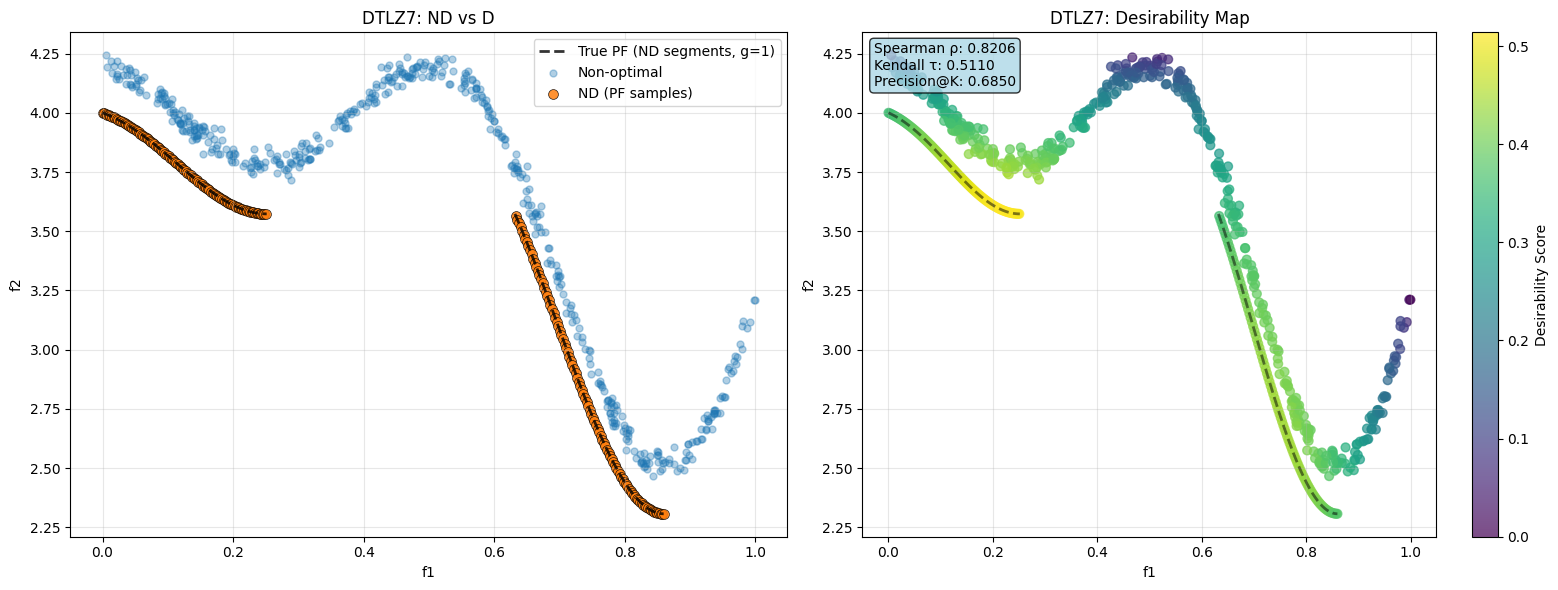


Top 10 Solutions by Desirability Score:
 Rank       f1       f2  Desirability Type
    1 0.221524 3.585906      0.513943   ND
    2 0.219124 3.587991      0.513918   ND
    3 0.223924 3.583972      0.513903   ND
    4 0.216704 3.590246      0.513828   ND
    5 0.226345 3.582179      0.513798   ND
    6 0.214304 3.592631      0.513674   ND
    7 0.228745 3.580557      0.513629   ND
    8 0.211884 3.595183      0.513455   ND
    9 0.231165 3.579081      0.513392   ND
   10 0.209484 3.597859      0.513174   ND


In [15]:
import numpy as np
import matplotlib.pyplot as plt

from spotdesirability.utils.desirability import DMin, DOverall
from scipy.spatial.distance import cdist
from scipy.stats import spearmanr, kendalltau
import pandas as pd

# ============================================================
# DTLZ7 (2 objectives): utilities for constructing and plotting the true ND PF segments
# ============================================================
def check_nd_correctness(F, nd_indices):
    """Verify that the provided indices form a mathematically non-dominated set."""
    ND = F[nd_indices]
    D = np.delete(F, nd_indices, axis=0)
    for a in ND:
        for b in D:
            if np.all(b <= a) and np.any(b < a):
                print("❌ WRONG ND FOUND:", a)
                return False
    print("✔ All ND points are mathematically correct.")
    return True

def pareto_front_2d_min(F, eps=1e-12):
    """Extract the 2D non-dominated subset for minimization, sorted by f1."""
    order = np.argsort(F[:, 0])
    Fs = F[order]
    best = np.inf
    keep = np.zeros(len(Fs), dtype=bool)
    for i in range(len(Fs)):
        if Fs[i, 1] < best - eps:
            keep[i] = True
            best = Fs[i, 1]
    return Fs[keep]

def make_segmented_line(x, y, gap_x=0.03):
    """Insert NaNs between distant x-values to prevent line-bridging across PF gaps."""
    x = np.asarray(x).copy()
    y = np.asarray(y).copy()
    dx = np.diff(x)
    jump_idx = np.where(dx > gap_x)[0]
    x_out, y_out = x, y
    for idx in jump_idx[::-1]:
        x_out = np.insert(x_out, idx + 1, np.nan)
        y_out = np.insert(y_out, idx + 1, np.nan)
    return x_out, y_out

def generate_true_pf_dtlz7_2obj_nd(n_points=50000, n_var=21):
    """Generate a dense approximation of the true ND PF for DTLZ7 with 2 objectives.

    Procedure:
      1) sample x0 uniformly in [0,1]
      2) set remaining variables to 0 so g=1 (DTLZ7 formulation)
      3) evaluate the resulting objective curve
      4) extract the non-dominated subset in objective space
    """
    x0 = np.linspace(0.0, 1.0, n_points)
    X_pf = np.zeros((n_points, n_var))
    X_pf[:, 0] = x0
    X_pf[:, 1:] = 0.0  # g=1

    F_curve = dtlz7(X_pf, n_obj=2)
    F_pf_nd = pareto_front_2d_min(F_curve)
    return F_pf_nd

def select_pf_samples_from_nd(F_pf_nd, n_pareto=200):
    """Select approximately uniform samples (in index space) from the dense ND PF set."""
    F_pf_nd = F_pf_nd[np.argsort(F_pf_nd[:, 0])]
    if len(F_pf_nd) <= n_pareto:
        return F_pf_nd.copy()
    idx = np.linspace(0, len(F_pf_nd) - 1, n_pareto).astype(int)
    return F_pf_nd[idx]

# -----------------------------
# Dataset generation (DTLZ7, 2 objectives)
# Strategy: inject ND points from true PF segments + single-band dominated samples
# -----------------------------
def generate_dtlz7_dataset_single_band_true_nd(
    n_nonopt=500, n_pareto=200, n_var=21, seed=42,
    x1_band=(0.0, 0.08), hidden_band=(0.0, 0.02),
    pf_dense_points=50000
):
    rng = np.random.default_rng(seed)

    # 1) Build dense ND PF segments (objective space), then downsample for injected ND set
    F_pf_nd_dense = generate_true_pf_dtlz7_2obj_nd(n_points=pf_dense_points, n_var=n_var)
    F_pf_nd = select_pf_samples_from_nd(F_pf_nd_dense, n_pareto=n_pareto)

    # 2) Map selected PF samples back to decision space (x0 = f1 on the g=1 curve)
    x0_pf = F_pf_nd[:, 0]
    X_pareto_full = np.zeros((len(x0_pf), n_var))
    X_pareto_full[:, 0] = x0_pf
    X_pareto_full[:, 1:] = 0.0
    F_nd = dtlz7(X_pareto_full, n_obj=2)

    # 3) Dominated set: small bands in x1 and hidden variables to keep samples near PF
    X_nonopt_full = np.zeros((n_nonopt, n_var))
    X_nonopt_full[:, 0] = rng.random(n_nonopt)
    X_nonopt_full[:, 1] = rng.uniform(x1_band[0], x1_band[1], size=n_nonopt)
    X_nonopt_full[:, 2:] = rng.uniform(hidden_band[0], hidden_band[1], size=(n_nonopt, n_var - 2))
    X_nonopt_full[:, 1:] = np.clip(X_nonopt_full[:, 1:], 0.0, 1.0)
    F_d = dtlz7(X_nonopt_full, n_obj=2)

    # Combine + labels (ND first)
    F = np.vstack([F_nd, F_d])
    labels = np.zeros(len(F))
    labels[:len(F_nd)] = 1.0

    return F, F_nd, F_d, labels, F_pf_nd_dense

# -----------------------------
# Run
# -----------------------------
n_nonopt = 500
n_pareto = 200
n_var = 21
seed = 42

F, nd_points, d_points, labels, F_pf_nd_dense = generate_dtlz7_dataset_single_band_true_nd(
    n_nonopt=n_nonopt, n_pareto=n_pareto, n_var=n_var, seed=seed,
    x1_band=(0.0, 0.08), hidden_band=(0.0, 0.02),
    pf_dense_points=50000
)

K = len(nd_points)
nds = np.arange(K)

print(f"✓ Total: {len(F)} points ({len(nd_points)} ND + {len(d_points)} Non-optimal)")
check_nd_correctness(F, nds)

# -----------------------------
# Desirability scoring
# -----------------------------
f1_min, f1_max = F[:, 0].min(), F[:, 0].max()
f2_min, f2_max = F[:, 1].min(), F[:, 1].max()

d_funcs = [
    DMin(f1_min, f1_max, scale=1),
    DMin(f2_min, f2_max, scale=1),
]
D_scores = DOverall(*d_funcs).predict(F)
D_scores = np.maximum(D_scores, 0)

print(f"✓ Desirability scores range: [{D_scores.min():.4f}, {D_scores.max():.4f}]")

# -----------------------------
# Distance-to-front correlation (Spearman)
# Dense reference set is the ND PF segments computed above
# -----------------------------
dist_to_pf = np.min(cdist(F, F_pf_nd_dense), axis=1)
rho_dist, _ = spearmanr(D_scores, -dist_to_pf)

tau, _ = kendalltau(D_scores, labels)
sorted_idx = np.argsort(-D_scores)
topK_idx = sorted_idx[:K]
precision_at_k = labels[topK_idx].sum() / K

print("=" * 60)
print("DESIRABILITY FUNCTION METRICS (DTLZ7, 2 objectives)")
print("=" * 60)
print(f"Spearman ρ (D_scores vs -dist_to_PF_dense): {rho_dist:.4f}")
print(f"Kendall τ (D_scores vs ND-labels):         {tau:.4f}")
print(f"Precision@K (K={K}):                        {precision_at_k:.4f}")
print("=" * 60)

# -----------------------------
# Plots (avoid connecting lines across disconnected PF segments)
# -----------------------------
F_pf_plot = F_pf_nd_dense[np.argsort(F_pf_nd_dense[:, 0])]
pf_x_seg, pf_y_seg = make_segmented_line(F_pf_plot[:, 0], F_pf_plot[:, 1], gap_x=0.03)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

axes[0].plot(pf_x_seg, pf_y_seg, "k--", linewidth=2, label="True PF (ND segments, g=1)", alpha=0.8)
axes[0].scatter(d_points[:, 0], d_points[:, 1], s=25, alpha=0.35, label="Non-optimal")
axes[0].scatter(
    nd_points[:, 0], nd_points[:, 1],
    s=50, alpha=0.85, label="ND (PF samples)",
    edgecolors="black", linewidth=0.5
)
axes[0].set_xlabel("f1")
axes[0].set_ylabel("f2")
axes[0].set_title("DTLZ7: ND vs D")
axes[0].grid(True, alpha=0.3)
axes[0].legend()

sc = axes[1].scatter(F[:, 0], F[:, 1], c=D_scores, cmap="viridis", s=40, alpha=0.7)
axes[1].plot(pf_x_seg, pf_y_seg, "k--", linewidth=2, alpha=0.5)
axes[1].set_xlabel("f1")
axes[1].set_ylabel("f2")
axes[1].set_title("DTLZ7: Desirability Map")
axes[1].grid(True, alpha=0.3)
cbar = plt.colorbar(sc, ax=axes[1])
cbar.set_label("Desirability Score")

txt = (f"Spearman ρ: {rho_dist:.4f}\n"
       f"Kendall τ: {tau:.4f}\n"
       f"Precision@K: {precision_at_k:.4f}")
axes[1].text(
    0.02, 0.98, txt, transform=axes[1].transAxes,
    va="top", fontsize=10,
    bbox=dict(boxstyle="round", facecolor="lightblue", alpha=0.8)
)

plt.tight_layout()
plt.show()

# -----------------------------
# Top 10 solutions
# -----------------------------
top10_idx = sorted_idx[:10]
top10_data = pd.DataFrame({
    "Rank": range(1, 11),
    "f1": F[top10_idx, 0],
    "f2": F[top10_idx, 1],
    "Desirability": D_scores[top10_idx],
    "Type": ["ND" if labels[i] == 1 else "D" for i in top10_idx],
})
print("\nTop 10 Solutions by Desirability Score:")
print(top10_data.to_string(index=False))
